# Coronawiki dataset Analysis

# **Intro**

In this first section we will expose each dataset used to answer our research questions, and will include statistical descriptions when suitable, pre-processing pipelines and remodeling in order to have a clear picture of the available material and have it under the most practical form for the data analysis pipeline that will follow.

This section will be further broken down into four main categories; 
* [Initial analysis](#Initial-analysis)
    * [Mobility](#Mobility)
        * [Apple Mobility preliminary analysis](#Apple-Mobility-preliminary-analysis)
        * [Global mobility dataset primary analysis](#Global-mobility-dataset-primary-analysis)
        * [Interventions time](#Interventions-time)
    * [Online research topics](#Online-research-topics) (Wikipedia, Google trends)
        * [Wikipedia searches primary analysis](#Wikipedia-searches-primary-analysis)
        * [Ecology searches (Wikipedia articles) preliminary analysis](#Ecology-searches-(Wikipedia-articles)-preliminary-analysis)
        * [Google trends](#Google-trends)
    * [Air quality](#Air-quality)
        * [Global air quality data](#Global-air-quality-data)
    * [General demographics](#General-demographics) (covid cases and deaths, timeline of events)
        * [Covid cases demographics](#Covid-cases-demographics)
        

And finally the [Project pipeline](#Project-pipeline) (With a case exemple)

## Setup and libraries

In [2]:
#Libraries

import pandas as pd
%matplotlib inline
import math
import seaborn as sns
import warnings
import numpy as np

import os
import gzip
import json
import pickle
import datetime
import pandas as pd

import pycountry_convert as pc
import pycountry

from pytrends.request import TrendReq

import xlrd as xlrd

from statsmodels.stats import diagnostic
from scipy import stats

from matplotlib import pyplot as plt

from helpers.helper_func import *

In [3]:
#Files paths

DATA_FOLDER = 'data/'

INTERVENTION_DATASET = DATA_FOLDER+"interventions.csv"
GLOBAL_MOBILITY = DATA_FOLDER+"Global_Mobility_Report.csv.gz"
TIME_SERIE_DATASET = DATA_FOLDER+"aggregated_timeseries.json.gz"
APPLE_MOBILITY = DATA_FOLDER+"applemobilitytrends-2020-04-20.csv.gz"
TOPICS_DATASET=DATA_FOLDER+"topics_linked.csv.xz"
COVID_CASES_GZ = DATA_FOLDER + "added_data/owid-covid-data.csv.gz"
AIR_QUALITY = DATA_FOLDER + "added_data/airquality_data_2020_concat.csv.gz"
DEGROWTH_WORLD_TREND = DATA_FOLDER + "added_data/DegrowthWorldTrend.csv"
ECOLOGY_WOLRD_TREND = DATA_FOLDER + "added_data/EcologyWorldTrend.csv"

# **Initial analysis**

# Mobility

## Apple Mobility preliminary analysis
This dataset exposes the mobility changes in a multitude of countries and for three main transportation type `walking`, `driving`, and `transit`

In [4]:
apple_mobility = pd.read_csv(APPLE_MOBILITY,compression='gzip', low_memory=False)

#Correction required for coherence in the table
apple_mobility=apple_mobility.replace('Republic of Korea','South Korea')
apple_mobility=apple_mobility.replace('UK','United Kingdom')
apple_mobility['2020-01-13']=apple_mobility['2020-01-13'].astype('float64') #By default the first day is '100' for all, not as float

apple_mobility.head()


geo_type     region transportation_type  2020-01-13  2020-01-14  \
0  country/region    Albania             driving       100.0       95.30   
1  country/region    Albania             walking       100.0      100.68   
2  country/region  Argentina             driving       100.0       97.07   
3  country/region  Argentina             walking       100.0       95.11   
4  country/region  Australia             driving       100.0      102.98   

   2020-01-15  2020-01-16  2020-01-17  2020-01-18  2020-01-19  ...  \
0      101.43       97.20      103.55      112.67      104.83  ...   
1       98.93       98.46      100.85      100.13       82.13  ...   
2      102.45      111.21      118.45      124.01       95.44  ...   
3      101.37      112.67      116.72      114.14       84.54  ...   
4      104.21      108.63      109.08       89.00       99.35  ...   

   2020-04-11  2020-04-12  2020-04-13  2020-04-14  2020-04-15  2020-04-16  \
0       25.47       24.89       32.64       31.43       30.67       30.00   
1       27.63       29.59       35.52       38.08       35.48       39.15   
2       19.40       12.89       21.10       22.29       23.55       24.40   
3       15.75       10.45       16.35       16.66       17.42       18.18   
4       26.95       31.72       53.14       55.91       56.56       58.77   

   2020-04-17  2020-04-18  2020-04-19  2020-04-20  
0       29.26       22.94       24.55       31.51  
1       34.58       27.76       27.93       36.72  
2       27.17       23.19       14.54       26.67  
3       18.80       17.03       10.59       18.44  
4       47.51       36.90       53.34       56.93  

[5 rows x 102 columns]

In [4]:
print("The number of NA values in the dataset is {}".format(apple_mobility.isna().sum().sum()))

The number of NA values in the dataset is 0


The mobility percent changes are all computed with reference to the first day (which is set to 100 for all)

In [5]:
apple_mobility.groupby('geo_type').nunique()[['region','transportation_type']]

region  transportation_type
geo_type                                   
city                89                    3
country/region      63                    3

We have two type of regions of interests, `city` and `country/region`, we will most likely focus on `country/region` as the other types of data are more easily accessible at this scale. 
Next we keep only the data for the `country/region` and we add the information of `continent`

In [5]:
# take only countries and regions, not city
apple_mobility_country = apple_mobility[apple_mobility['geo_type']=='country/region'].copy()

#find the corresponding continents
listed = apple_mobility_country['region'].copy()
continents = [] 
for i in range(len(listed)):
    alpha2 = pc.country_name_to_country_alpha2(listed[i],cn_name_format = "default")
    cont = pc.country_alpha2_to_continent_code(alpha2)
    continents.append(cont)
    
apple_mobility_country.loc[:,'continent']=continents

#put continent as first 4th column
apple_mobility_country.insert(3, 'continent', apple_mobility_country.pop('continent'))

In [50]:
#What are the continents represented, and in which proportions ?
apple_mobility_country.groupby('continent').nunique()[['region','transportation_type']]

region  transportation_type
continent                             
AF              3                    2
AS             17                    3
EU             33                    3
NA              3                    3
OC              2                    3
SA              5                    3

6 continents are represented, the most documented one being Europe, the least (propotionnaly to the number of existing countries) being Africa, which has no data for one of the transportation type (`transit`).

We can now define a method to plot the evolution of different types of mobilities depending on the continent of interest

In [61]:
#PLot the different type of mobilities evolution by continents
sns.set_style(style='white') 
def plot_mobility(dataset, regions):
    
    fig, axs = plt.subplots(len(regions),3, sharex=True,figsize=(25,5*len(regions)),squeeze = False)

    fig.supxlabel("Time (in Days)")
    fig.supylabel("Percent change from baseline")
    fig.tight_layout()
    i=0
    
    for region in regions:
        transit = dataset[(dataset.transportation_type == "transit") & (dataset.continent == region)]
        driving = dataset[(dataset.transportation_type == "driving") & (dataset.continent == region)]
        walking = dataset[(dataset.transportation_type == "walking") & (dataset.continent == region)]
        axs[i][0].set_facecolor('white')

        if (region != "AF"):  #There is no transit data in Africa and this creates problem with the vline plotting
            transit.loc[:,(transit.dtypes == 'float64').values].apply(axs[i][0].plot, axis=1)
            axs[i][0].set_title("Transit in " + region)
            axs[i][0].legend(transit.region, ncol = 3, prop = {'size': 8})
            axs[i][0].vlines("2020-03-11", ymin = 0, ymax = 160, label = "mobility restrictions")
            axs[i][0].xaxis.set_tick_params(labelrotation = 90, labelsize=8)
            axs[i][0].xaxis.set_major_locator(plt.MaxNLocator(10))
            axs[i][0].set_facecolor('white')
            


        driving.loc[:,(driving.dtypes == 'float64').values].apply(axs[i][1].plot, axis = 1)
        axs[i][1].set_title("Driving in " + region)
        axs[i][1].legend(driving.region, ncol = 3, prop = {'size': 8})
        axs[i][1].vlines("2020-03-11", ymin = 0, ymax = 160, label = "mobility restrictions")
        axs[i][1].xaxis.set_tick_params(labelrotation = 90, labelsize = 8)
        axs[i][1].set_facecolor('white')


        walking.loc[:,(walking.dtypes == 'float64').values].apply(axs[i][2].plot, axis = 1)
        axs[i][2].set_title("Walking in " + region)
        axs[i][2].legend(walking.region, ncol = 3, prop = {'size': 8})
        axs[i][2].vlines("2020-03-11", ymin = 0, ymax = 160, label = "mobility restrictions")
        axs[i][2].xaxis.set_tick_params(labelrotation = 90, labelsize = 8)
        axs[i][2].set_facecolor('white')

        
        i = i+1
    
    
    fig.suptitle("Mobility evolution by continents", fontsize=24)

    #leave space at the top for the title
    fig.subplots_adjust(top=0.9)
    
    plt.show()    

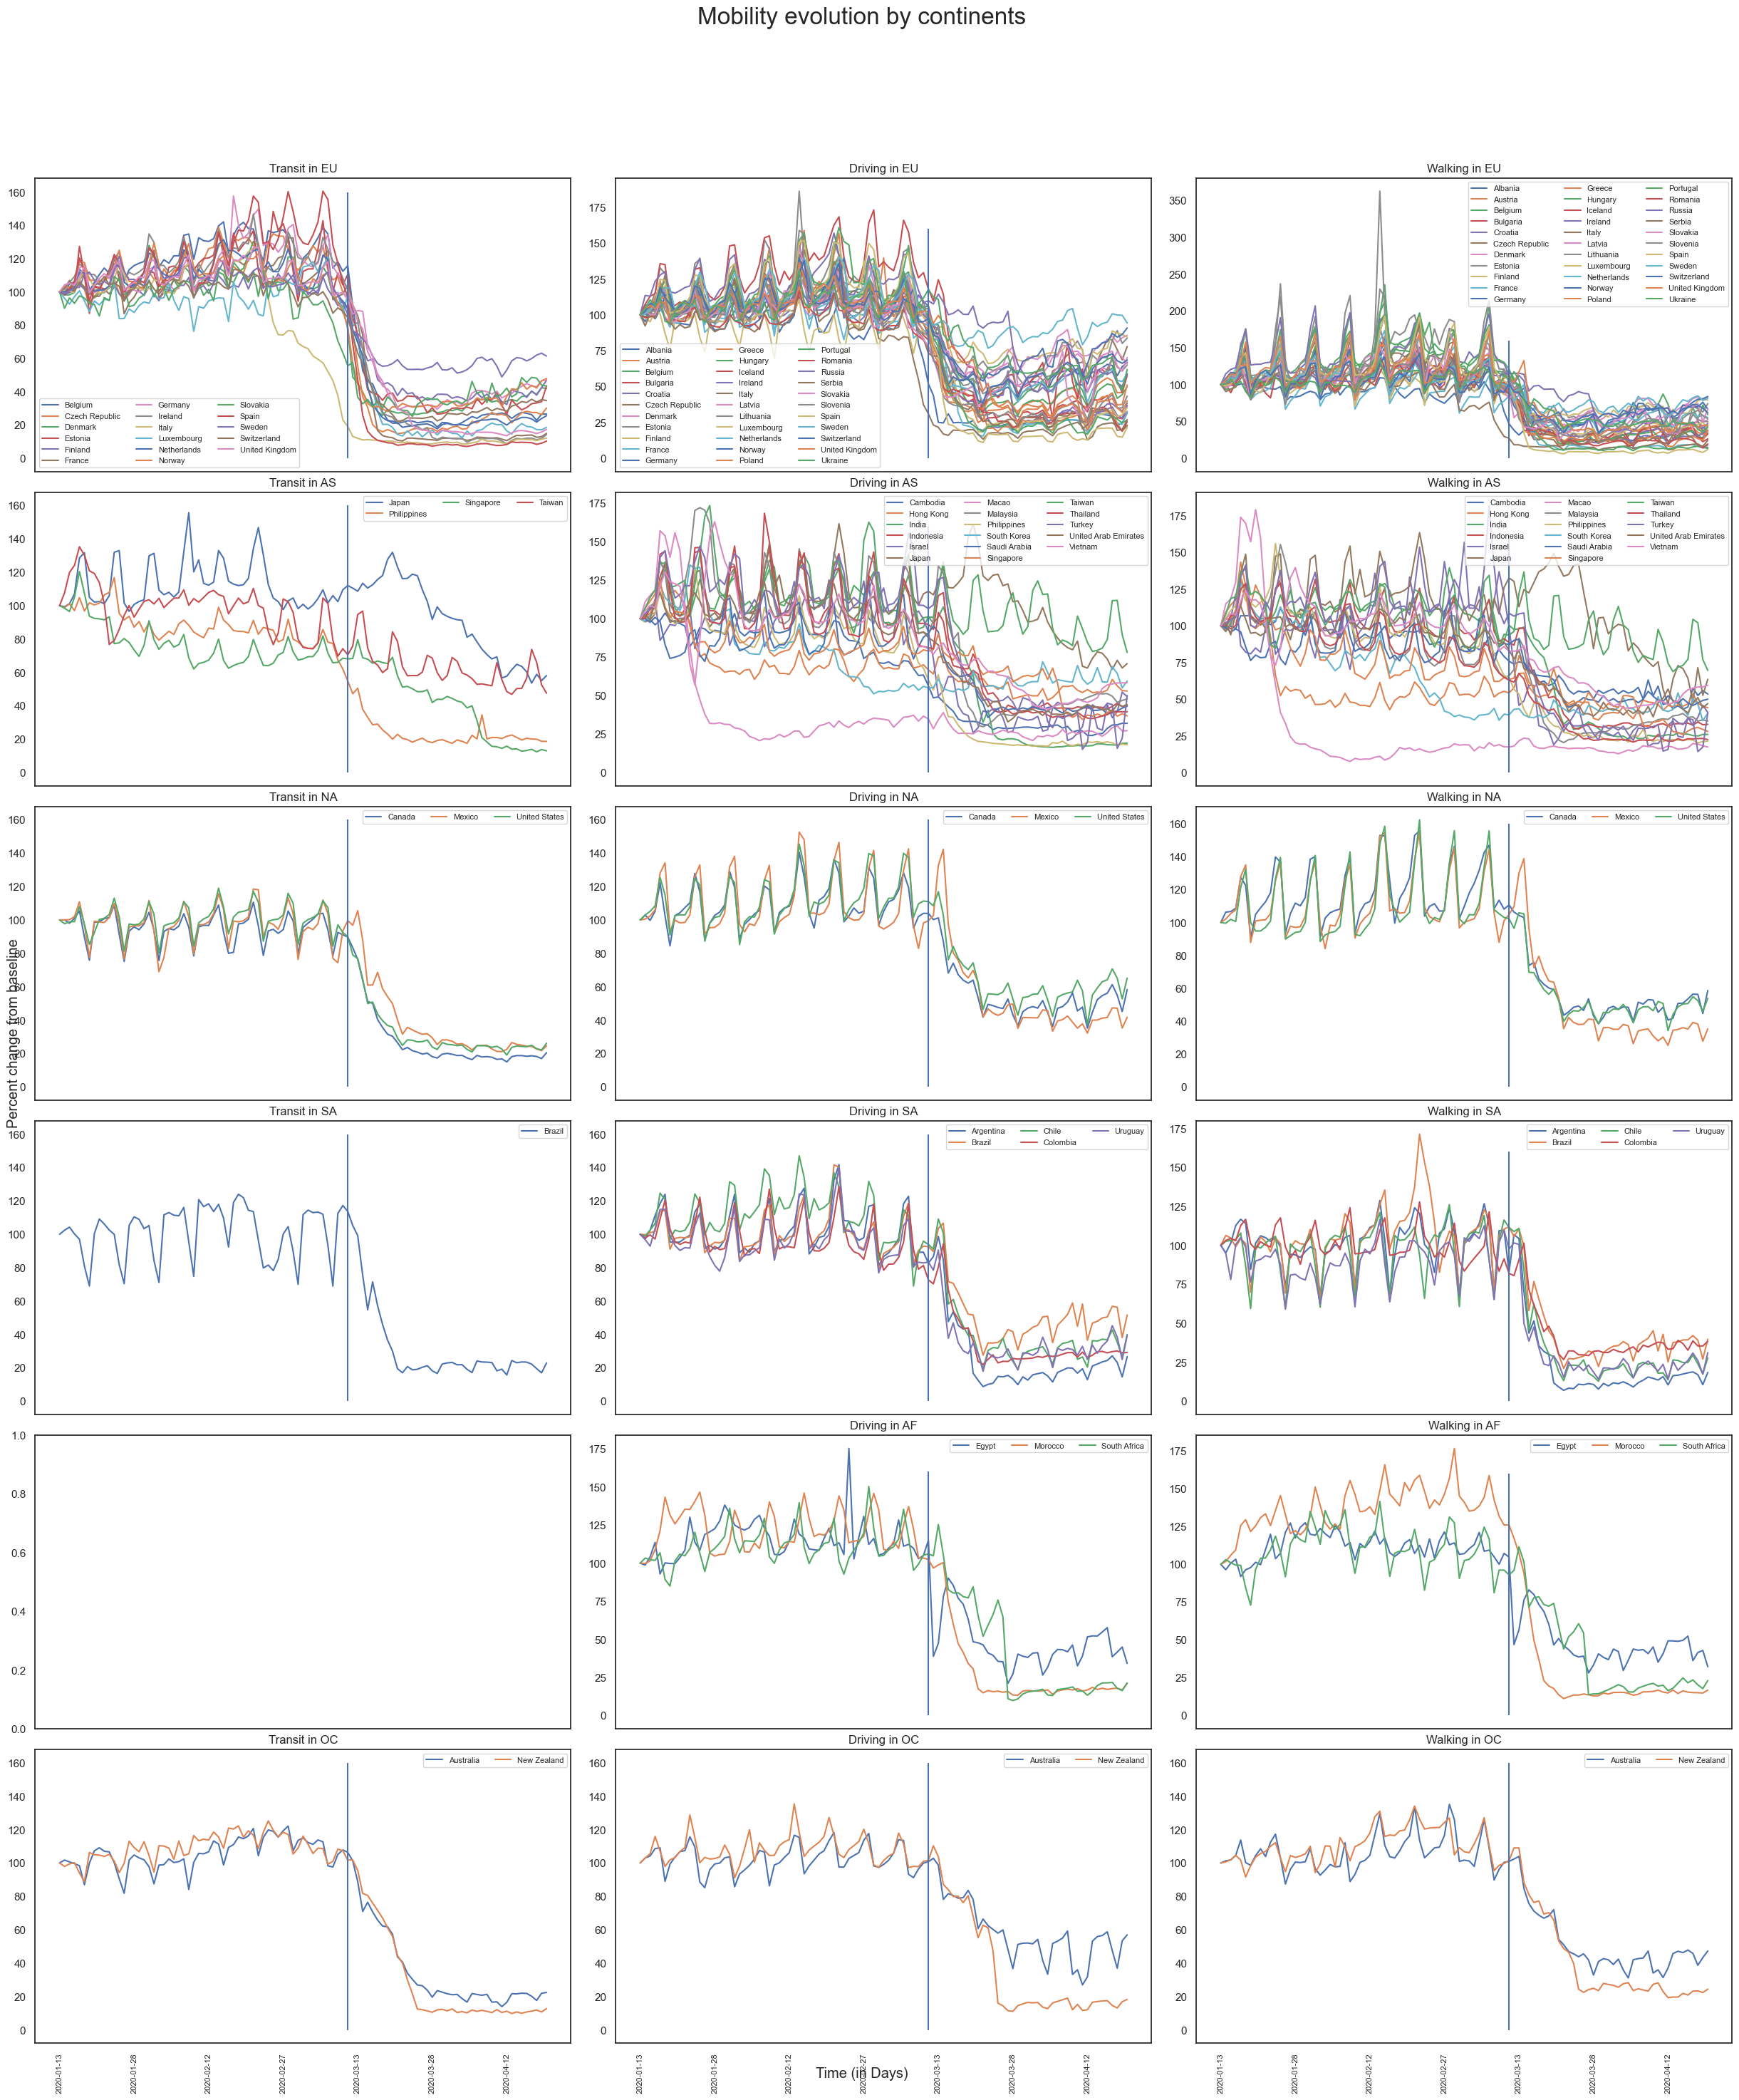

In [62]:
plot_mobility(apple_mobility_country, ["EU","AS","NA","SA","AF","OC"])


The blue line indicates the first mobility restriction, and except for the transit in Asia, all other configuration show a drastic drop in mobility after the first measures, as expected.

However, on unsmoothed data we observe weekly trends in the different mobility behavior, which we can furhter investigate


In [6]:
# expected format 'yyyy-mm-dd'
def to_day(date):
    year, month, day = (int(x) for x in date.split('-'))    
    ans = datetime.date(year, month, day)
    return (ans.strftime("%A"))

In [64]:
# create dataframe date & day
day = np.vectorize(to_day)

col_dates = apple_mobility_country.iloc[:,4:].columns
date_df = pd.DataFrame()
date_df['date'] = col_dates
date_df['day'] = day(col_dates)

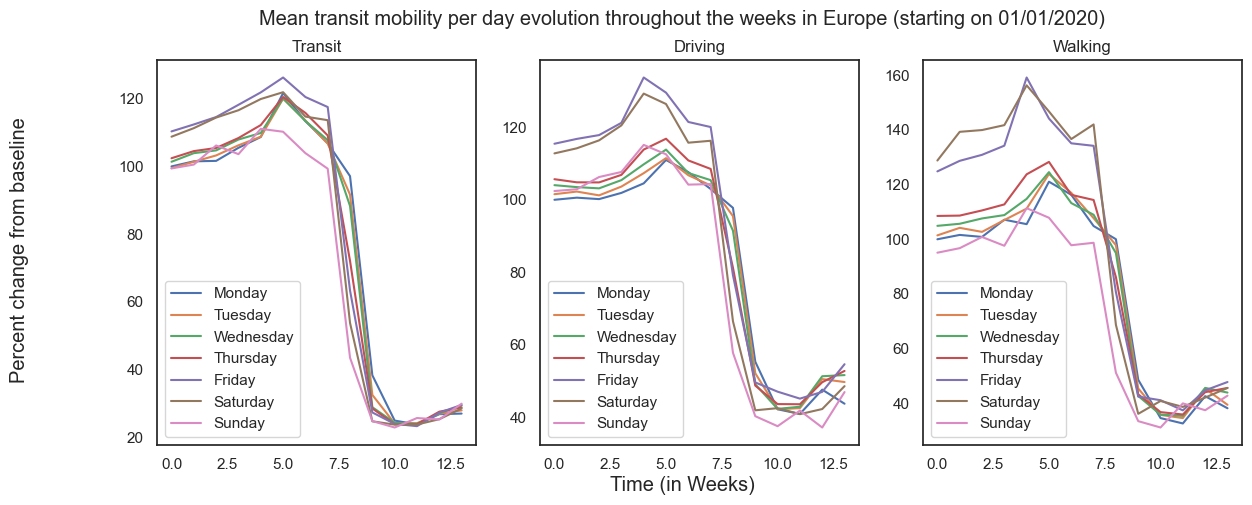

In [68]:
days = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
fig, axs = plt.subplots(1,3, sharex = True, figsize = (14,5))
fig.supxlabel("Time (in Weeks)")
fig.supylabel("Percent change from baseline")
fig.suptitle("Mean transit mobility per day evolution throughout the weeks in Europe (starting on 01/01/2020)")
 
for day in days:
    days_indf = date_df[date_df.day == day].date
    transit_test = apple_mobility_country[(apple_mobility_country.transportation_type == "transit") & (apple_mobility_country.continent == "EU")]
    transit_test_day = transit_test.loc[:,days_indf]
    default_x_ticks = range(14)
    axs[0].plot(default_x_ticks,transit_test_day.mean()[0:14],label=day)
    axs[0].set_title("Transit")
    axs[0].legend()
    
for day in days:
    days_indf = date_df[date_df.day == day].date
    transit_test = apple_mobility_country[(apple_mobility_country.transportation_type == "driving") & (apple_mobility_country.continent == "EU")]
    transit_test_day = transit_test.loc[:,days_indf]
    default_x_ticks = range(14)
    axs[1].plot(default_x_ticks,transit_test_day.mean()[0:14],label=day)
    axs[1].set_title("Driving")
    axs[1].legend()
    
for day in days:
    days_indf = date_df[date_df.day == day].date
    transit_test = apple_mobility_country[(apple_mobility_country.transportation_type == "walking") & (apple_mobility_country.continent == "EU")]
    transit_test_day = transit_test.loc[:,days_indf]
    default_x_ticks = range(14)
    axs[2].plot(default_x_ticks,transit_test_day.mean()[0:14],label=day)
    axs[2].set_title("Walking")
    axs[2].legend()


Fridays and Saturdays seem to be consistently higher across every category, at least before the lockdown. After the lockdown the trend is not really observable anymore and the weekly life rythm was disturbed

To ease the visual representation and have more meaningful trends, the data can (and should) be smoothed on a weekly basis (using a rolling window of 7 days)

In [7]:
#smooth data on 7 day period to be able to observe the real trends

apple_mobility_country_smoothed = apple_mobility_country.copy()
apple_mobility_country_smoothed.loc[:,'2020-01-13':'2020-04-20'] = apple_mobility_country_smoothed.loc[:,'2020-01-13':'2020-04-20'].rolling(7, axis = 1, min_periods = 1).mean()


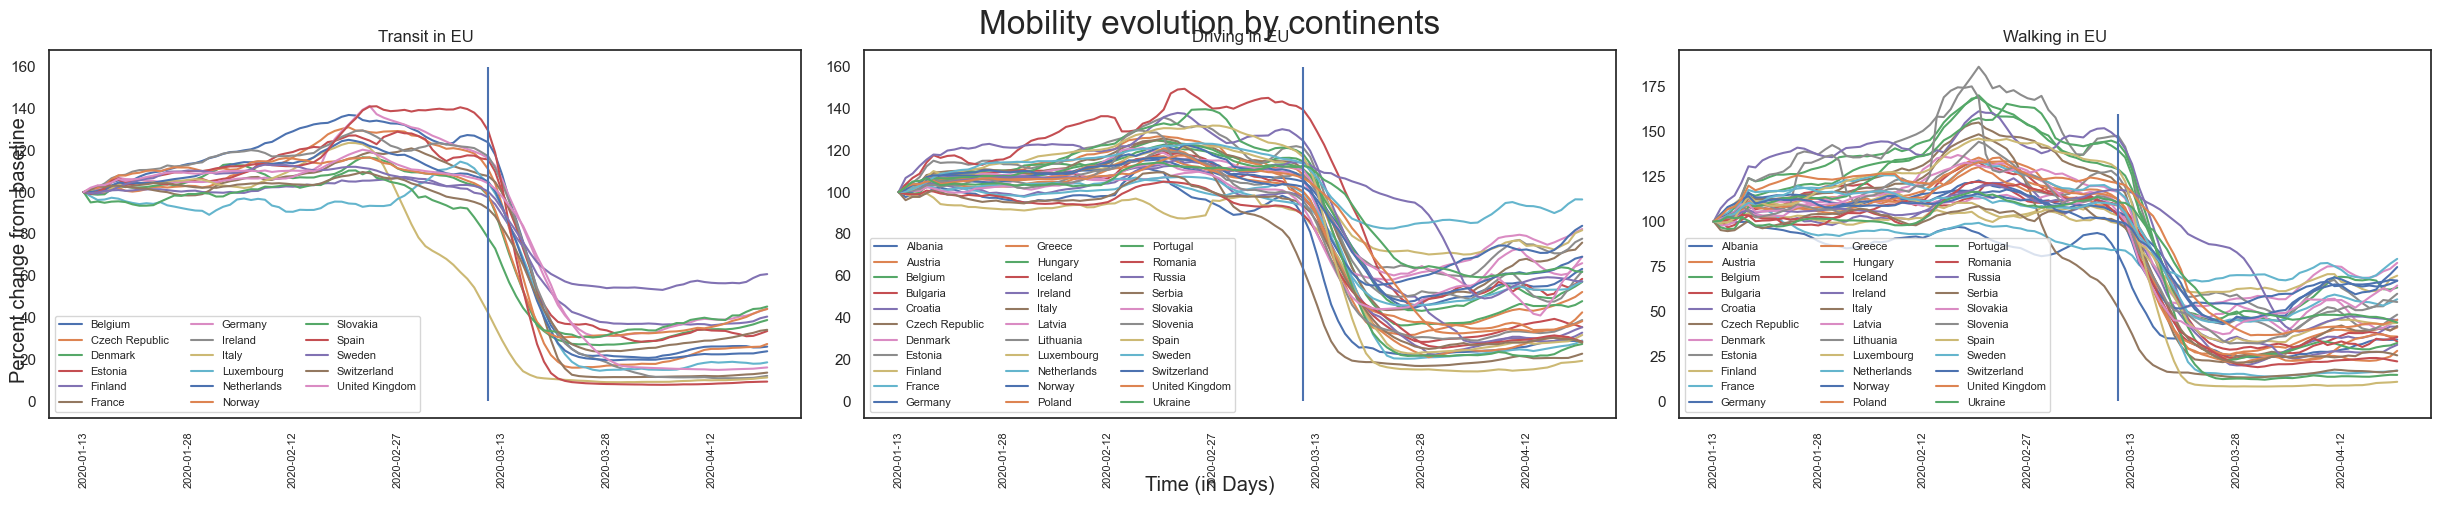

In [67]:
#Example only in Europe

plot_mobility(apple_mobility_country_smoothed, ["EU"])

We now have data separated by countries and transit type, with the added information of continent and day of the week and smoothed on a weekly basis. 

## Global mobility dataset primary analysis

In the continuity of the apple mobility dataset, this global mobility dataset provides information on the differentially occupied places

In [8]:
global_mobility = pd.read_csv(GLOBAL_MOBILITY,compression = 'gzip', low_memory = False)
global_mobility.head()

country_region_code        country_region sub_region_1 sub_region_2  \
0                  AE  United Arab Emirates          NaN          NaN   
1                  AE  United Arab Emirates          NaN          NaN   
2                  AE  United Arab Emirates          NaN          NaN   
3                  AE  United Arab Emirates          NaN          NaN   
4                  AE  United Arab Emirates          NaN          NaN   

  metro_area iso_3166_2_code  census_fips_code        date  \
0        NaN             NaN               NaN  2020-02-15   
1        NaN             NaN               NaN  2020-02-16   
2        NaN             NaN               NaN  2020-02-17   
3        NaN             NaN               NaN  2020-02-18   
4        NaN             NaN               NaN  2020-02-19   

   retail_and_recreation_percent_change_from_baseline  \
0                                                0.0    
1                                                1.0    
2                                               -1.0    
3                                               -2.0    
4                                               -2.0    

   grocery_and_pharmacy_percent_change_from_baseline  \
0                                                4.0   
1                                                4.0   
2                                                1.0   
3                                                1.0   
4                                                0.0   

   parks_percent_change_from_baseline  \
0                                 5.0   
1                                 4.0   
2                                 5.0   
3                                 5.0   
4                                 4.0   

   transit_stations_percent_change_from_baseline  \
0                                            0.0   
1                                            1.0   
2                                            1.0   
3                                            0.0   
4                                           -1.0   

   workplaces_percent_change_from_baseline  \
0                                      2.0   
1                                      2.0   
2                                      2.0   
3                                      2.0   
4                                      2.0   

   residential_percent_change_from_baseline  
0                                       1.0  
1                                       1.0  
2                                       1.0  
3                                       1.0  
4                                       1.0

In [16]:
global_mobility.isna().sum()

country_region_code                                      1498
country_region                                              0
sub_region_1                                            38330
sub_region_2                                           381949
metro_area                                            2099002
iso_3166_2_code                                       1717957
census_fips_code                                      1609817
date                                                        0
retail_and_recreation_percent_change_from_baseline     768130
grocery_and_pharmacy_percent_change_from_baseline      789458
parks_percent_change_from_baseline                    1133768
transit_stations_percent_change_from_baseline         1061956
workplaces_percent_change_from_baseline                106383
residential_percent_change_from_baseline              1053764
dtype: int64

We see that only date and country region is defined for every value, which is expected for some subcatgories such as sub_region and metro_area. We must however be careful when handeling the percent changes from baseline for different defined regions

As before, we would like to keep only information related to countries and with the added value of continent

In [9]:
countries = global_mobility.groupby('country_region').nunique().index

#take only countries
global_mobility_countries = global_mobility[global_mobility['sub_region_1'].isna() & global_mobility['sub_region_2'].isna() & global_mobility['metro_area'].isna() & -global_mobility['country_region_code'].isna()].copy()
listed = global_mobility_countries.country_region_code.values

#add continent information
continents = []
for i in range(len(listed)):
    cont = pc.country_alpha2_to_continent_code(listed[i])
    continents.append(cont)
global_mobility_countries['continent'] = continents

#displace the continent column
global_mobility_countries.insert(1, 'continent', global_mobility_countries.pop('continent'))

global_mobility_countries.head()
global_mobility_countries.rename(columns = {'country_region':'Country'}, inplace = True)

Take only the data for Europe and group by countries

In [16]:

mean_globality_europe_percent_change_col = ['retail_and_recreation_percent_change_from_baseline','grocery_and_pharmacy_percent_change_from_baseline','parks_percent_change_from_baseline','transit_stations_percent_change_from_baseline','workplaces_percent_change_from_baseline','residential_percent_change_from_baseline']
mean_globality_europe = global_mobility_countries[(global_mobility_countries.continent=='EU')].groupby(['Country','date'])[mean_globality_europe_percent_change_col].mean()


In [17]:
mean_globality_europe

retail_and_recreation_percent_change_from_baseline  \
Country        date                                                             
Austria        2020-02-15                                                9.0    
               2020-02-16                                               15.0    
               2020-02-17                                                9.0    
               2020-02-18                                                8.0    
               2020-02-19                                                4.0    
...                                                                      ...    
United Kingdom 2020-08-21                                              -24.0    
               2020-08-22                                              -30.0    
               2020-08-23                                              -25.0    
               2020-08-24                                               -1.0    
               2020-08-25                                              -11.0    

                           grocery_and_pharmacy_percent_change_from_baseline  \
Country        date                                                            
Austria        2020-02-15                                                1.0   
               2020-02-16                                               21.0   
               2020-02-17                                                5.0   
               2020-02-18                                                5.0   
               2020-02-19                                                2.0   
...                                                                      ...   
United Kingdom 2020-08-21                                              -11.0   
               2020-08-22                                              -13.0   
               2020-08-23                                              -15.0   
               2020-08-24                                              -10.0   
               2020-08-25                                              -14.0   

                           parks_percent_change_from_baseline  \
Country        date                                             
Austria        2020-02-15                                42.0   
               2020-02-16                                42.0   
               2020-02-17                                35.0   
               2020-02-18                                40.0   
               2020-02-19                                10.0   
...                                                       ...   
United Kingdom 2020-08-21                                65.0   
               2020-08-22                                61.0   
               2020-08-23                                73.0   
               2020-08-24                               120.0   
               2020-08-25                                43.0   

                           transit_stations_percent_change_from_baseline  \
Country        date                                                        
Austria        2020-02-15                                           13.0   
               2020-02-16                                           12.0   
               2020-02-17                                            3.0   
               2020-02-18                                            2.0   
               2020-02-19                                           -1.0   
...                                                                  ...   
United Kingdom 2020-08-21                                          -39.0   
               2020-08-22                                          -31.0   
               2020-08-23                                          -28.0   
               2020-08-24                                          -37.0   
               2020-08-25                                          -44.0   

                           workplaces_percent_change_from_baseline  \
Country        date        

As seen before, the mobility is cyclic on a weekly basic, to better see trends we need to smooth the data with a rolling window of size 7

In [70]:
#smooth data on weekly basis
mean_globality_europe_percent_change_col_smoothed = [s + "_smoothed" for s in mean_globality_europe_percent_change_col]
mean_globality_europe[mean_globality_europe_percent_change_col_smoothed] = mean_globality_europe[mean_globality_europe_percent_change_col].rolling(7).mean()
                      

For exemple in Switzerland (but also similarly in different countries), the time spent in retail and recreation, transit stations and workplaces dropped significantly, whereas the tipe spent at home increased. The time spent in parks tends to increase but the trend is less clear.

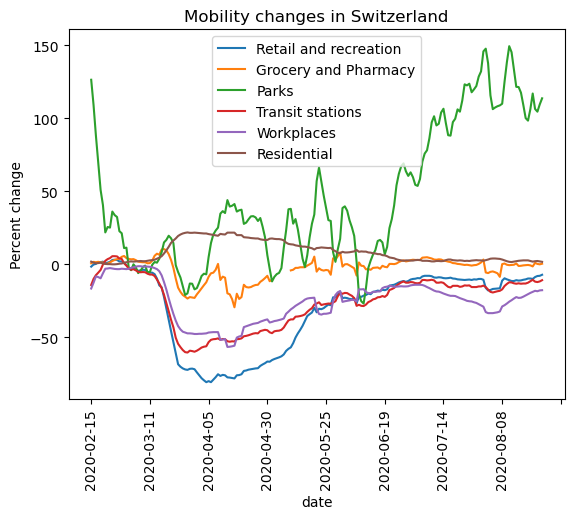

In [9]:
mean_globality_europe.loc['Switzerland',mean_globality_europe_percent_change_col_smoothed].plot()
plt.legend(['Retail and recreation','Grocery and Pharmacy','Parks','Transit stations','Workplaces','Residential'])
plt.xticks(rotation=90)
plt.ylabel('Percent change')
plt.title('Mobility changes in Switzerland')
plt.show()

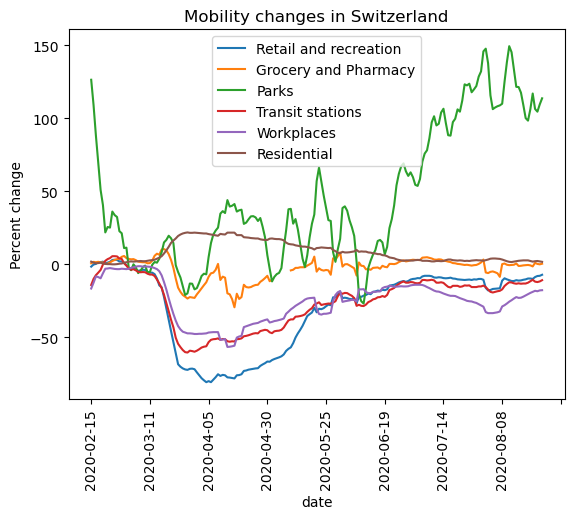

In [9]:
mean_globality_europe.loc['Switzerland',mean_globality_europe_percent_change_col_smoothed].plot()
plt.legend(['Retail and recreation','Grocery and Pharmacy','Parks','Transit stations','Workplaces','Residential'])
plt.xticks(rotation=90)
plt.ylabel('Percent change')
plt.title('Mobility changes in Switzerland')
plt.show()

In [22]:
mean_globality_europe.loc['Switzerland',:].isna().sum()

retail_and_recreation_percent_change_from_baseline             0
grocery_and_pharmacy_percent_change_from_baseline              1
parks_percent_change_from_baseline                             0
transit_stations_percent_change_from_baseline                  0
workplaces_percent_change_from_baseline                        0
residential_percent_change_from_baseline                       0
retail_and_recreation_percent_change_from_baseline_smoothed    0
grocery_and_pharmacy_percent_change_from_baseline_smoothed     7
parks_percent_change_from_baseline_smoothed                    0
transit_stations_percent_change_from_baseline_smoothed         0
workplaces_percent_change_from_baseline_smoothed               0
residential_percent_change_from_baseline_smoothed              0
dtype: int64

Some values are missing, but using the smoothing window, we can still get a good trend estimation

### Interventions time
To guide us in the data interpretation, we also have access to the date of the major events for a number of countries ( `1st case`, `1st death`, `School closure`, `Public events banned`, `Mobility`)

In [55]:
interventions = pd.DataFrame(load_interventions("data/interventions.csv"))
events = pd.DataFrame.from_dict(interventions)
events.head(10)

fr         da         de         it         nl  \
1st case             2020-01-24 2020-02-27 2020-01-27 2020-01-31 2020-02-27   
1st death            2020-02-14 2020-03-12 2020-03-09 2020-02-22 2020-03-06   
School closure       2020-03-14 2020-03-13 2020-03-14 2020-03-05 2020-03-11   
Public events banned 2020-03-13 2020-03-12 2020-03-22 2020-03-09 2020-03-24   
Lockdown             2020-03-17 2020-03-18 2020-03-22 2020-03-11 2020-03-23   
Mobility             2020-03-16 2020-03-11 2020-03-16 2020-03-11 2020-03-16   
Normalcy             2020-07-02 2020-06-05 2020-07-10 2020-06-26 2020-05-29   

                             no         sr         sv         ko         ca  \
1st case             2020-02-26 2020-03-06 2020-01-31 2020-01-20 2020-01-31   
1st death            2020-02-26 2020-03-20 2020-03-11 2020-02-20 2020-02-13   
School closure       2020-03-13 2020-03-15 2020-03-18 2020-02-23 2020-03-12   
Public events banned 2020-03-12 2020-03-21 2020-03-12        NaT 2020-03-08   
Lockdown             2020-03-24 2020-03-21        NaT        NaT 2020-03-14   
Mobility             2020-03-11 2020-03-16 2020-03-11 2020-02-25 2020-03-16   
Normalcy             2020-06-04 2020-05-02 2020-06-05 2020-04-15        NaT   

                             fi         ja         en  
1st case             2020-01-29 2020-01-16        NaT  
1st death            2020-03-21 2020-02-13        NaT  
School closure       2020-03-16 2020-02-27        NaT  
Public events banned 2020-03-16 2020-02-25        NaT  
Lockdown                    NaT        NaT        NaT  
Mobility             2020-03-16 2020-03-31 2020-03-16  
Normalcy             2020-05-21 2020-06-14 2020-05-21

We could also find a 'mean' date for each event

# Online research topics

## Wikipedia searches primary analysis

In this datatest, we have access to the aggregated wikipedia topics

In [24]:
#Loading the data
aggregate_dict = load_aggregated("data/aggregated_timeseries.json.gz")
topics_df, topics_list = load_topics('data/topics_linked.csv.xz')

In [25]:
#List of aggregated topics

list(aggregate_dict['ja.m']['topics'])

['Culture.Biography.Biography*',
 'Culture.Biography.Women',
 'Culture.Food and drink',
 'Culture.Internet culture',
 'Culture.Linguistics',
 'Culture.Literature',
 'Culture.Media.Books',
 'Culture.Media.Entertainment',
 'Culture.Media.Films',
 'Culture.Media.Media*',
 'Culture.Media.Music',
 'Culture.Media.Radio',
 'Culture.Media.Software',
 'Culture.Media.Television',
 'Culture.Media.Video games',
 'Culture.Performing arts',
 'Culture.Philosophy and religion',
 'Culture.Sports',
 'Culture.Visual arts.Architecture',
 'Culture.Visual arts.Comics and Anime',
 'Culture.Visual arts.Fashion',
 'Culture.Visual arts.Visual arts*',
 'Geography.Geographical',
 'Geography.Regions.Africa.Africa*',
 'Geography.Regions.Africa.Central Africa',
 'Geography.Regions.Africa.Eastern Africa',
 'Geography.Regions.Africa.Northern Africa',
 'Geography.Regions.Africa.Southern Africa',
 'Geography.Regions.Africa.Western Africa',
 'Geography.Regions.Americas.Central America',
 'Geography.Regions.Americas.North

In [26]:
columns = ["sr", "it", "fr", "en", "nl", "ko", "de", "fi", "ja", "no", "sv", "da"]
ecology_desktop = pd.DataFrame()
ecology_mobile = pd.DataFrame()
ecology_agg = pd.DataFrame()
all_agg = pd.DataFrame()

for country in columns:
    ecology_desktop[country] = pd.DataFrame.from_dict(aggregate_dict[country]['topics']['STEM.Earth and environment']['sum'])
    colname_mobile = country+'.m'
    ecology_mobile[colname_mobile] = pd.DataFrame.from_dict(aggregate_dict[colname_mobile]['topics']['STEM.Earth and environment']['sum'])
    colname_agg = country+'.agg'
    ecology_agg[colname_agg] = pd.DataFrame.from_dict(aggregate_dict[colname_mobile]['topics']['STEM.Earth and environment']['sum']) + pd.DataFrame.from_dict(aggregate_dict[country]['topics']['STEM.Earth and environment']['sum'])

In [27]:
ecology_desktop.head()

sr     it      fr       en     nl    ko      de    fi     ja  \
2018-01-01  1282  20273   60078   709659  12191  5120   84060  4987  38004   
2018-01-02  1956  41790   92710   973197  22430  5995  145048  7407  46235   
2018-01-03  2150  45349  104062  1115237  28073  7069  171493  7117  55066   
2018-01-04  2628  47540  106732  1097507  24522  6201  157776  7637  73793   
2018-01-05  2368  43588   98577  1016865  21832  5942  143471  6912  85140   

              no  sv    da  
2018-01-01  2906   0  1987  
2018-01-02  6096   0  4289  
2018-01-03  8860   0  6872  
2018-01-04  9953   0  8372  
2018-01-05  8706   0  7605

 Plotting aggregated data for each country (red line = first case, green line = return to normalcy)

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


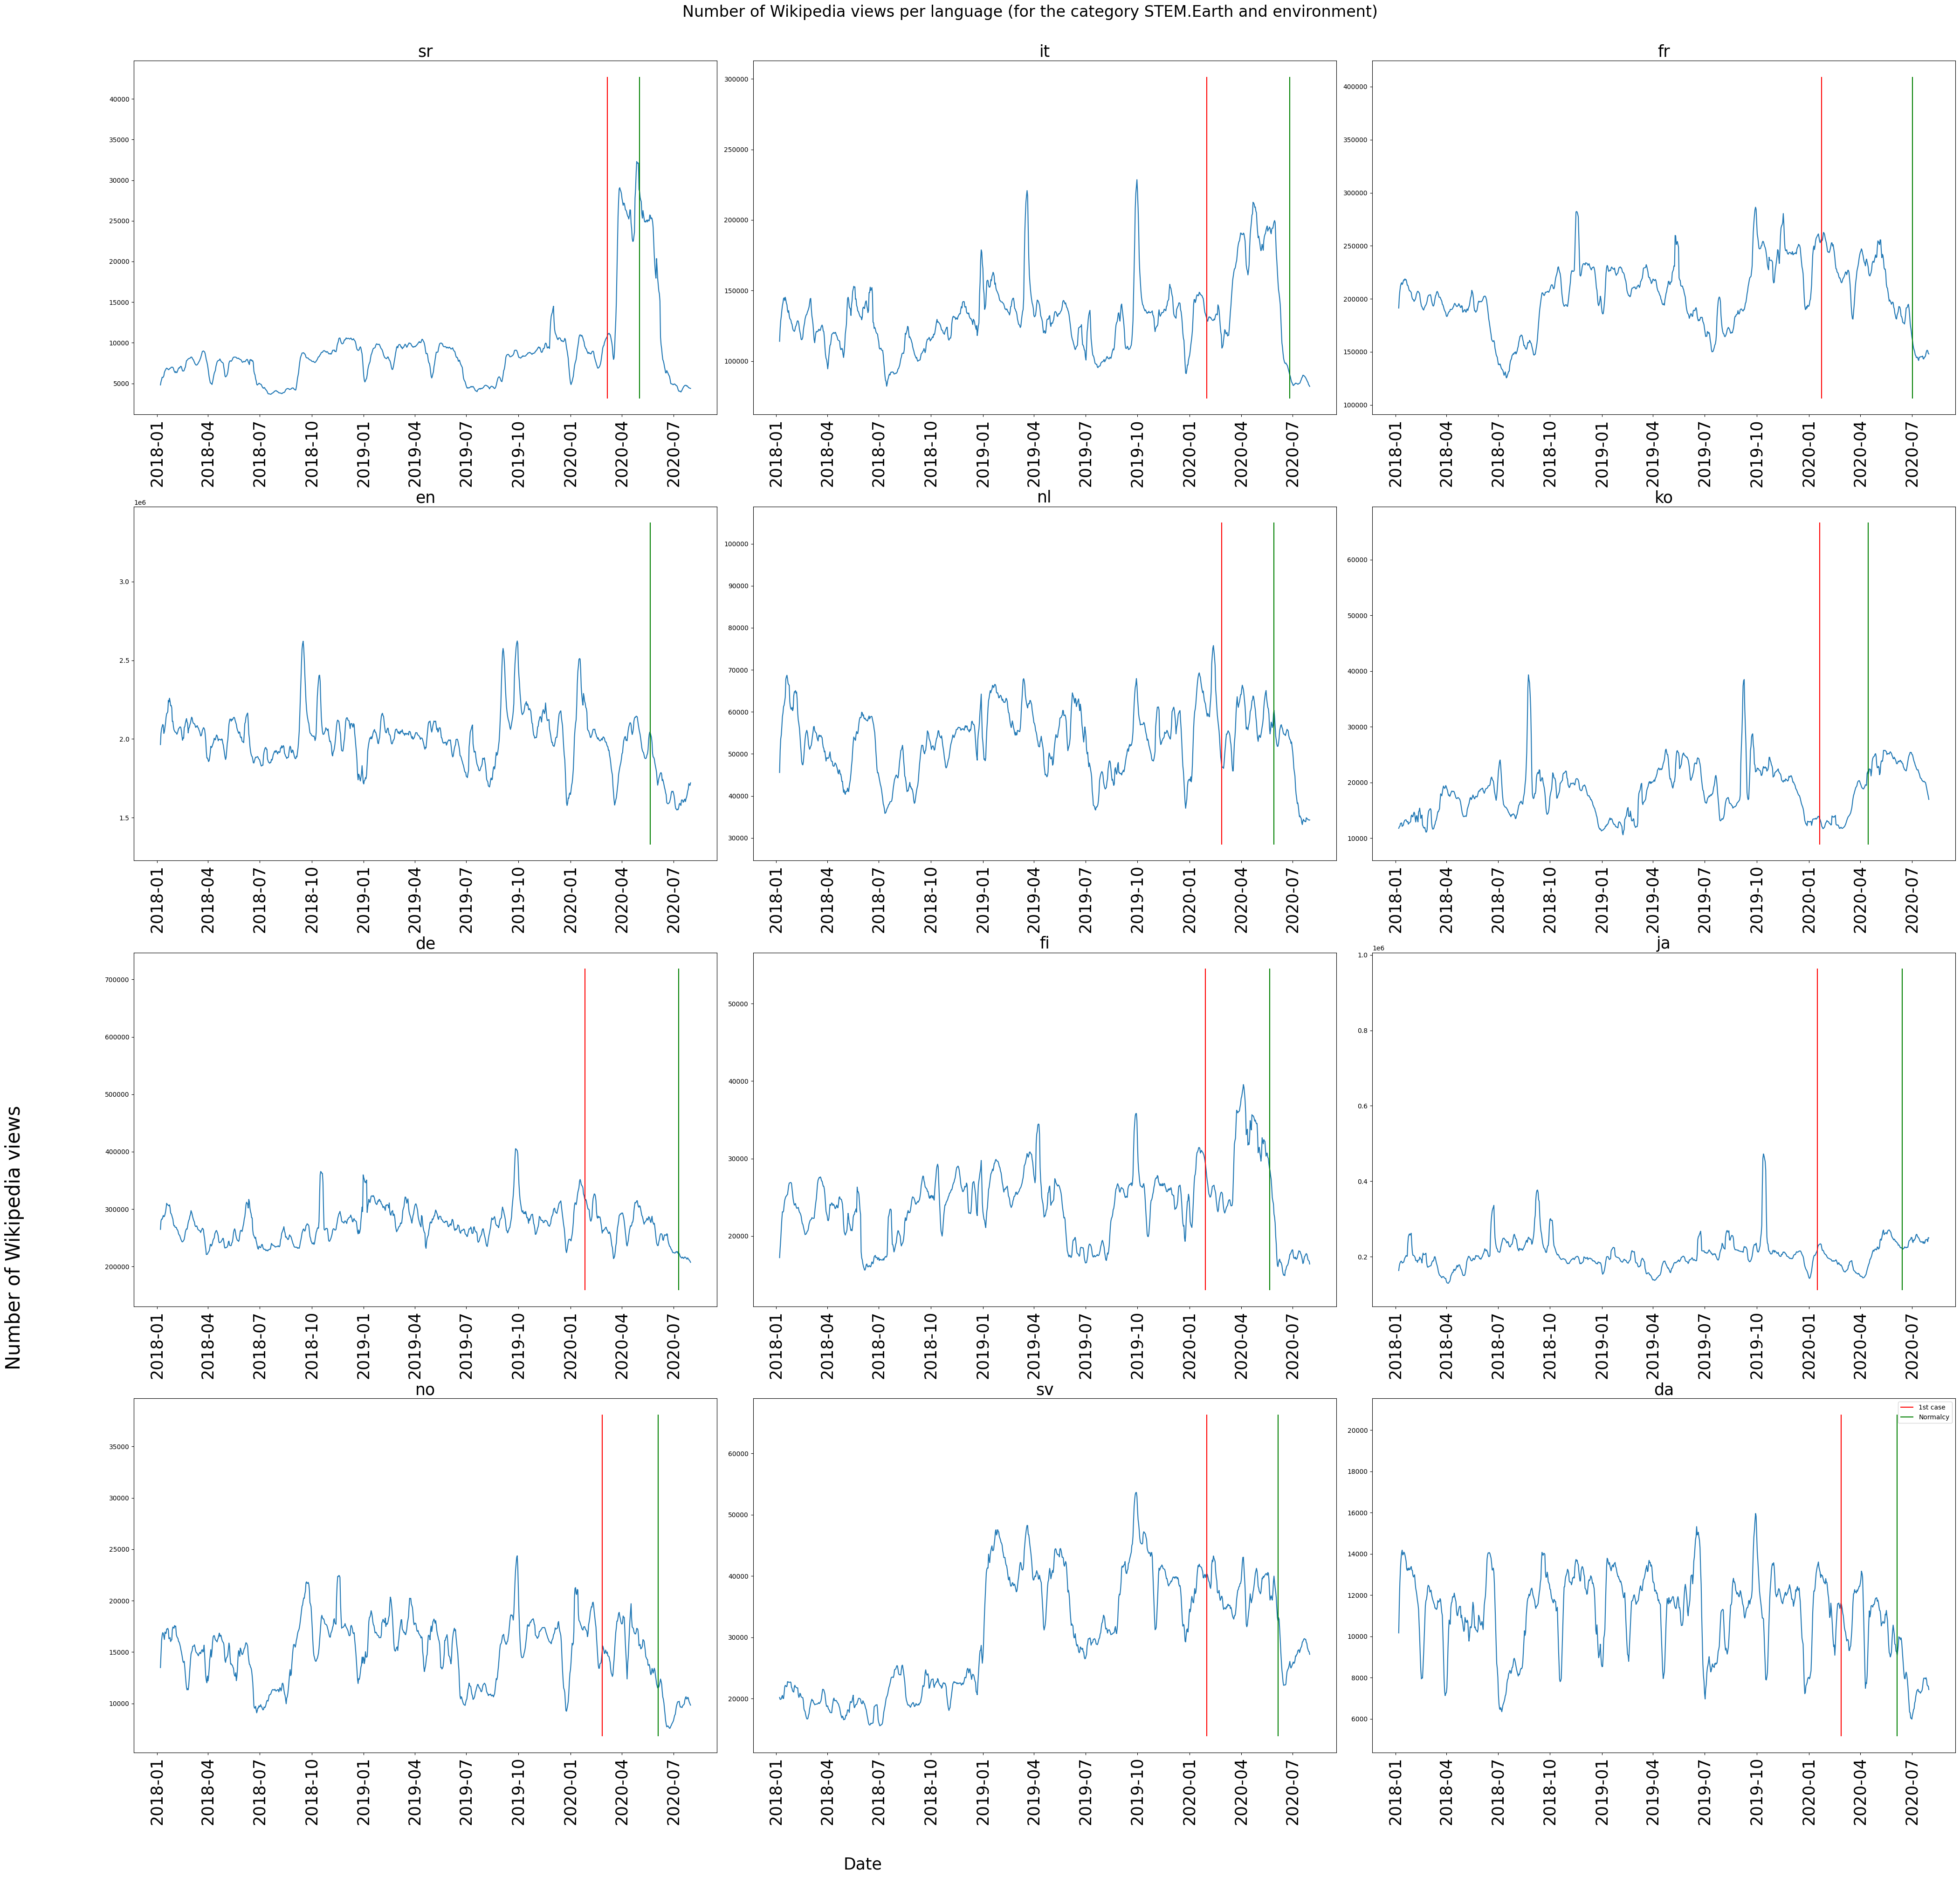

In [28]:
fig, ax = plt.subplots(4,3,figsize= (40, 40))
plt.subplots_adjust(hspace=0.5)
for country,ax in zip(columns, ax.ravel()):
    sbplt = ax
    sbplt.set_title(country, fontsize=25)
    sbplt.tick_params(axis='x', rotation=90,labelsize=25)
    sns.lineplot(data=ecology_agg[country+'.agg'].rolling(7).mean(), ax=sbplt)
    sbplt.vlines(interventions[country]['1st case'], ymin=pd.DataFrame.min(ecology_agg[country+'.agg']), ymax=pd.DataFrame.max(ecology_agg[country+'.agg']), color='red', label = '1st case')
    sbplt.vlines(interventions[country]['Normalcy'], ymin=pd.DataFrame.min(ecology_agg[country+'.agg']), ymax=pd.DataFrame.max(ecology_agg[country+'.agg']), color='green', label = 'Normalcy')
    sbplt.set(xlabel=None)
    sbplt.set(ylabel=None)
    
fig.tight_layout()
fig.text(0.4,-0.02, "Date", fontsize=25)
fig.text(-0.05,0.25, "Number of Wikipedia views", rotation = 90, fontsize=30)

fig.suptitle("Number of Wikipedia views per language (for the category STEM.Earth and environment)", fontsize=24)
fig.subplots_adjust(top=0.95)
plt.legend()
plt.show()

We can see that for the category `STEM.Earth and environment`, there is no clear trend and the behavior is different for each language. It would make more sense to look for a more specific category linked to the climate change (see [next section](#ecology-searches-wikipedia-articles-preliminary-analysis)) to see if in this case there is a trend

We can also look at a more global scale, if all categories are aggregated, wether there is a global trend in the number of english Wikipedia article consulted

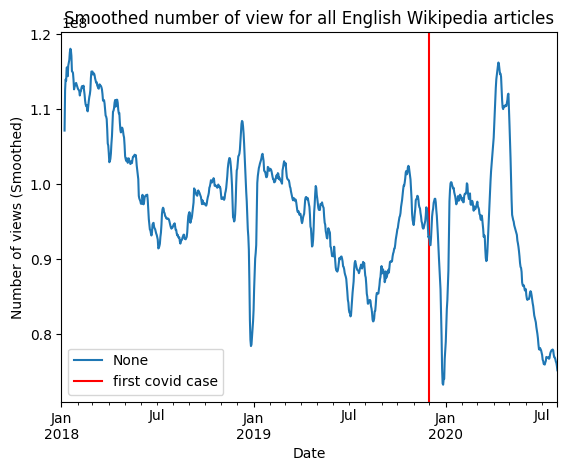

In [29]:
time_click = aggregate_dict['en']['sum']

time_click.rolling(7).mean().plot()
plt.title('Smoothed number of view for all English Wikipedia articles')
plt.xlabel('Date')
plt.ylabel('Number of views (Smoothed)')
plt.axvline('2019-12-01', ls="-", color="red", zorder=1, label = "first covid case")
plt.legend()
plt.show()

It is difficult to discern any trend at this scale,but we can use this information to see if a trend in a specific category is linked specially to this category or it just follows the global trend of the interest for Wikipedia

## Ecology searches (Wikipedia articles) preliminary analysis

We first perform a gross analysis on the number of searches regarding the topic *Climate change*

In [10]:
climate_change_search = "https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/en.wikipedia/all-access/all-agents/Climate_change/monthly/2019010100/2020123100"
climate_change_search = pd.read_json(climate_change_search)

In [31]:
climate_change_search.head()

items
0  {'project': 'en.wikipedia', 'article': 'Climat...
1  {'project': 'en.wikipedia', 'article': 'Climat...
2  {'project': 'en.wikipedia', 'article': 'Climat...
3  {'project': 'en.wikipedia', 'article': 'Climat...
4  {'project': 'en.wikipedia', 'article': 'Climat...

In [11]:
#put the timestamp and the number of views in a dataframe
#aplly to all items in the list the function
climate_change_df = climate_change_search
climate_change_df['views'] = climate_change_search['items'].apply(lambda x: x['views'])
climate_change_df['timestamp'] = climate_change_search['items'].apply(lambda x: x['timestamp'])

#convert timestamp to datetime
climate_change_df['timestamp'] = pd.to_datetime(climate_change_df['timestamp'], format='%Y%m%d%H')

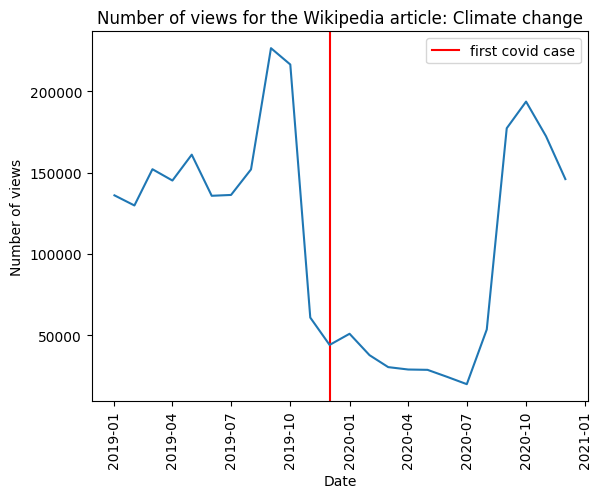

In [33]:
#plot number of views over time
plt.plot(climate_change_df['timestamp'],climate_change_df['views'])
plt.xticks(rotation = 90)
plt.ylabel('Number of views')
plt.title('Number of views for the Wikipedia article: Climate change')
plt.xlabel('Date')
plt.axvline(pd.to_datetime('2019-12-01'), ls="-", color="red", zorder=1, label = "first covid case")
plt.legend()
plt.show()

A first trend is clearly visible here, however we need to dig in a little bit and diversify the topics around *Climate change*. 

Data taken from [massviews](https://pageviews.wmcloud.org/massviews/), it is all articles from category [climate_change](https://en.wikipedia.org/wiki/Category:Climate_change)

In [12]:
climate_change_cat = 'data/added_data/massviews-20180101-20220101.csv'
climate_change_cat = pd.read_csv(climate_change_cat)
climate_change_cat = climate_change_cat.append(climate_change_cat.sum(axis=0),ignore_index=True)

climate_change_cat_fr = 'data/added_data/massviews-fr-20180101-20220101.csv'
climate_change_cat_fr = pd.read_csv(climate_change_cat_fr)
climate_change_cat_fr = climate_change_cat_fr.append(climate_change_cat_fr.sum(axis=0),ignore_index=True)

climate_change_cat_de = 'data/added_data/massviews-de-20180101-20220101.csv'
climate_change_cat_de = pd.read_csv(climate_change_cat_de)
climate_change_cat_de = climate_change_cat_de.append(climate_change_cat_de.sum(axis=0),ignore_index=True)

C:\Users\Salomé\AppData\Local\Temp\ipykernel_22300\72688184.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  climate_change_cat = climate_change_cat.append(climate_change_cat.sum(axis=0),ignore_index=True)
C:\Users\Salomé\AppData\Local\Temp\ipykernel_22300\72688184.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  climate_change_cat_fr = climate_change_cat_fr.append(climate_change_cat_fr.sum(axis=0),ignore_index=True)
C:\Users\Salomé\AppData\Local\Temp\ipykernel_22300\72688184.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  climate_change_cat_de = climate_change_cat_de.append(climate_change_cat_de.sum(axis=0),ignore_index=True)


In [35]:
climate_change_cat.head()

Title  2018-01-01  2018-01-02  2018-01-03  \
0                     Climate change        2332        3385        4089   
1  History of climate change science         209         294         331   
2                Climate engineering         264         340         488   
3                     Global cooling         599         772         938   
4                     Global dimming         121         158         216   

   2018-01-04  2018-01-05  2018-01-06  2018-01-07  2018-01-08  2018-01-09  \
0        4400        3441        3500        4040        5371        6092   
1         306         266         265         285         326         264   
2         463         416         371         400         426         461   
3         867         977         841         745         813         621   
4         206         200         193         180         177         191   

   ...  2021-12-23  2021-12-24  2021-12-25  2021-12-26  2021-12-27  \
0  ...        3401        4426        3669        4085        5030   
1  ...         162         191         173         234         236   
2  ...         185         136         132         199         192   
3  ...         186         228         187         224         366   
4  ...         114          85         115         122         122   

   2021-12-28  2021-12-29  2021-12-30  2021-12-31  2022-01-01  
0        4477        4437        4375        3809        3733  
1         220         238         233         233         183  
2         228         218         224         189         249  
3         409         293         305         234         199  
4         104         102         125         128         109  

[5 rows x 1463 columns]

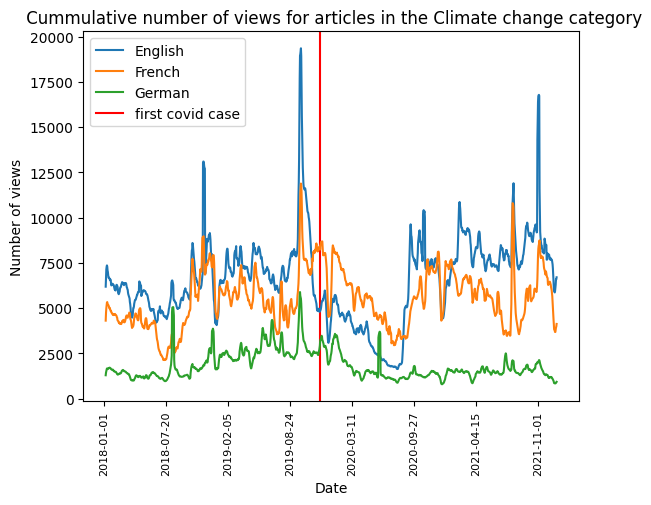

In [36]:
climate_change_cummaltive = climate_change_cat.iloc[climate_change_cat.shape[0]-1,1:].rolling(7).mean()
climate_change_fr_cummaltive = climate_change_cat_fr.iloc[climate_change_cat_fr.shape[0]-1,1:].rolling(7).mean()
climate_change_de_cummaltive = climate_change_cat_de.iloc[climate_change_cat_de.shape[0]-1,1:].rolling(7).mean()

plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.plot(climate_change_cummaltive.index,climate_change_cummaltive.values, label='English')
plt.plot(climate_change_fr_cummaltive.index,climate_change_fr_cummaltive.values, label='French')
plt.plot(climate_change_de_cummaltive.index,climate_change_de_cummaltive.values, label='German')
plt.xticks(rotation = 90, fontsize=8)
plt.ylabel('Number of views')
plt.title(' Cummulative number of views for articles in the Climate change category')
plt.xlabel('Date')
plt.axvline('2019-12-01', ls="-", color="red", zorder=1, label = "first covid case")
plt.legend()
plt.show()

Once again, the trend is confirmed, there seems to be a global decrease in the cummulative number of views during the covid lockdown

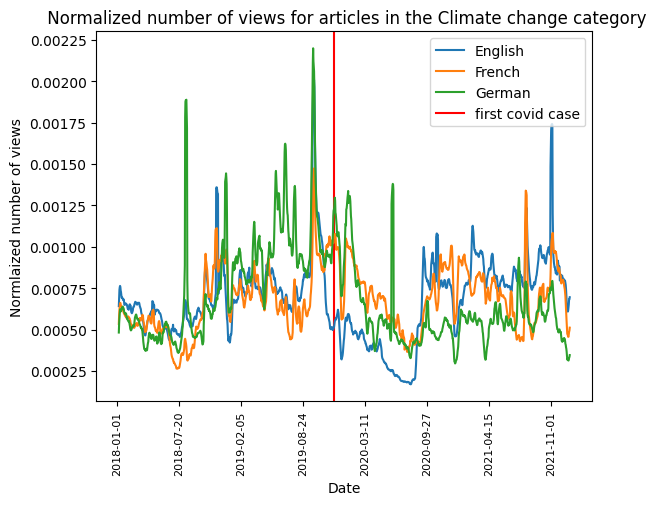

In [37]:
climate_change_cummaltive_per = climate_change_cummaltive/climate_change_cummaltive.sum()
climate_change_fr_cummaltive_per = climate_change_fr_cummaltive/climate_change_fr_cummaltive.sum()
climate_change_de_cummaltive_per = climate_change_de_cummaltive/climate_change_de_cummaltive.sum()

plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.plot(climate_change_cummaltive_per.index,climate_change_cummaltive_per.values, label='English')
plt.plot(climate_change_fr_cummaltive_per.index,climate_change_fr_cummaltive_per.values, label='French')
plt.plot(climate_change_de_cummaltive_per.index,climate_change_de_cummaltive_per.values, label='German')
plt.xticks(rotation = 90, fontsize=8)
plt.ylabel('Normlaized number of views')
plt.xlabel('Date')
plt.title(' Normalized number of views for articles in the Climate change category')
plt.axvline('2019-12-01', ls="-", color="red", zorder=1, label = "first covid case")
plt.legend()
plt.show()

If we normalize per number of views in each country, we observe that the overall trend is actually really similar between countries

## Google trends

Additionally, we might be further informed by the global web searches on the topic, rather than the specific look at Wikipedia articles. For this reason we access the google trends for subject related to ecology

In [38]:
degrowth = pd.read_csv(DEGROWTH_WORLD_TREND, skiprows=2)
ecology = pd.read_csv(ECOLOGY_WOLRD_TREND, skiprows=2)

In [39]:
first_events = events.min(axis = 'columns')
num_events = pd.to_datetime(first_events).map(datetime.datetime.toordinal)

/tmp/ipykernel_120/3543930962.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


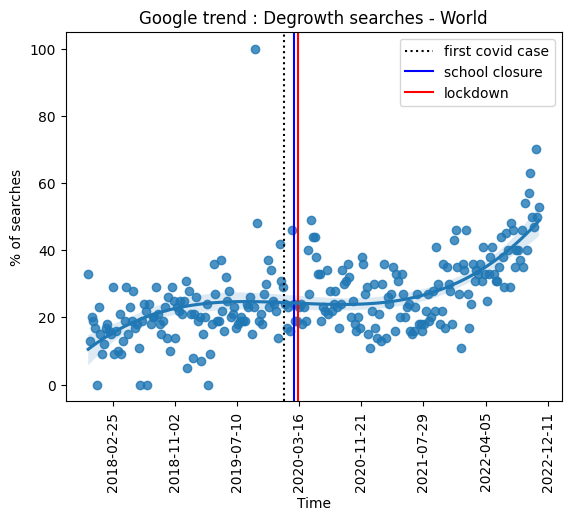

In [40]:
degrowth['date_time_ordinal']=pd.to_datetime(degrowth['Semaine']).map(datetime.datetime.toordinal)

ax = sns.regplot(
    data=degrowth,
    x='date_time_ordinal',
    y='degrowth: (Dans tous les pays)',
    order = 3
)
ax.set_xlabel('Time')

new_labels = [datetime.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
ax.tick_params(axis='x',rotation=90)
plt.title("Google trend : Degrowth searches - World")
plt.ylabel("% of searches")
plt.axvline(num_events[0], ls=":", color="black", zorder=1, label = "first covid case")
plt.axvline(num_events[2], ls="-", color="blue", zorder=1, label = "school closure")
plt.axvline(num_events[4], ls="-", color="red", zorder=1, label = "lockdown")
plt.legend()
plt.show()

The increasing interest in the topic of 'Degrowth' seems to be slowed down at the time of the pandemic, and also appears to be regaining interest recently

/tmp/ipykernel_120/2027583298.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(new_labels)


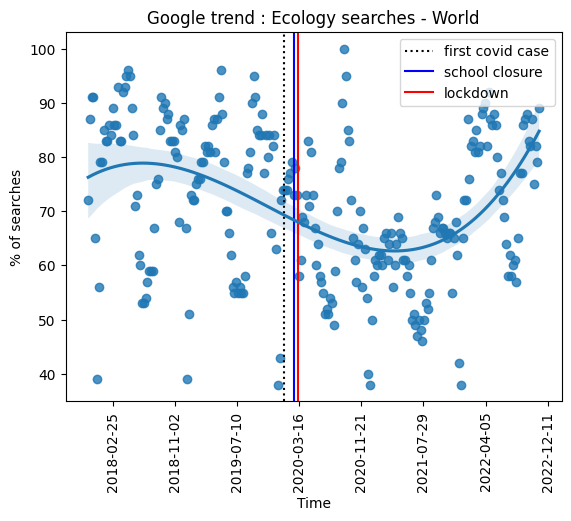

In [41]:
ecology['date_time_ordinal']=pd.to_datetime(degrowth['Semaine']).map(datetime.datetime.toordinal)

ax = sns.regplot(
    data=ecology,
    x='date_time_ordinal',
    y='ecology: (Dans tous les pays)',
    order=3
)
ax.set_xlabel('Time')

new_labels = [datetime.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
ax.tick_params(axis='x',rotation=90)
plt.title("Google trend : Ecology searches - World")
plt.ylabel("% of searches")
plt.axvline(num_events[0], ls=":", color="black", zorder=1, label = "first covid case")
plt.axvline(num_events[2], ls="-", color="blue", zorder=1, label = "school closure")
plt.axvline(num_events[4], ls="-", color="red", zorder=1, label = "lockdown")
plt.legend()
plt.show()

As it was observed with the Wikipedia article first analysis, the topic of Ecology reached a low point during the covid crisis and regained popularity recently

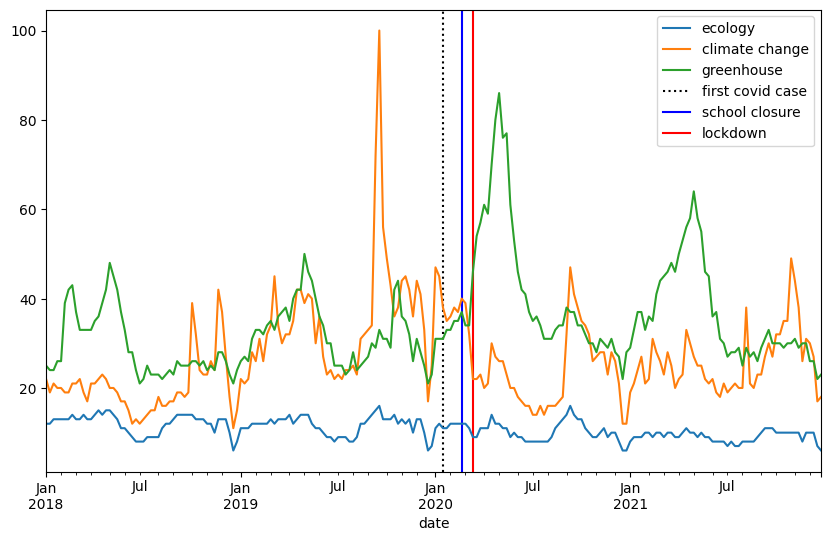

In [42]:
pytrend = TrendReq()

#provide your search terms
kw_list=['ecology', 'climate change', 'greenhouse']

#search interest per region
#run model for keywords (can also be competitors)
pytrend.build_payload(kw_list, timeframe='2018-01-01 2022-01-01')

#Interest over time
interest_over_time = pytrend.interest_over_time()
# Interest by Region
regiondf = pytrend.interest_by_region()
#looking at rows where all values are not equal to 0
regiondf = regiondf[(regiondf != 0).all(1)]
#drop all rows that have null values in all columns
regiondf.dropna(how='all',axis=0, inplace=True)
interest_over_time.dropna(how='all',axis=0, inplace=True)

#visualise
#regiondf.plot(figsize=(20, 12), y=kw_list, kind ='bar')
interest_over_time.plot(figsize=(10, 6))
plt.axvline('2020-01-16', ls=":", color="black", zorder=1, label = "first covid case")
plt.axvline('2020-02-23', ls="-", color="blue", zorder=1, label = "school closure")
plt.axvline('2020-03-11', ls="-", color="red", zorder=1, label = "lockdown")
plt.legend()

#### Correlation within researches

In [43]:
stats.pearsonr(interest_over_time['ecology'],interest_over_time['climate change'])

PearsonRResult(statistic=0.47902757332757506, pvalue=2.493685440985079e-13)

In [44]:
stats.pearsonr(interest_over_time['ecology'],interest_over_time['greenhouse'])

PearsonRResult(statistic=0.1619076039389467, pvalue=0.01946885896977825)

In [45]:
stats.pearsonr(interest_over_time['climate change'],interest_over_time['greenhouse'])

PearsonRResult(statistic=0.06423878538134822, pvalue=0.3566150024545376)

Both interactions are significantly related (p<0.05) but ecology has a stronger positive correlation with 'climate change' than 'greenhouse'. However climate change is not positively correlated with searches in greenhouse emissions


# Air quality


## Global air quality data

An dataset of the air quality already aggregated per country/city is available from [Air quality open platform](https://aqicn.org/data-platform/covid19/). It contains all large variaty of polutants ( `co`, `no2`, `o3`, `pm10`, `pm25`, `so2`)

In [46]:
air_quality_df= pd.read_csv(AIR_QUALITY,compression='gzip')

In [47]:
air_quality_df.head()

Date Country    City Specie  count  min   max  median  variance
0  2020-01-13      CO  Bogotá    so2    316  0.2   2.8     0.5      1.47
1  2020-02-25      CO  Bogotá    so2    335  0.1   4.1     0.8      3.25
2  2020-03-09      CO  Bogotá    so2    308  0.2   5.4     0.6      3.51
3  2020-03-13      CO  Bogotá    so2    333  0.2   3.7     0.8      3.45
4  2020-03-27      CO  Bogotá    so2    323  0.2  13.8     0.7     27.21

In [48]:
air_quality_df.isna().sum()

Date        0
Country     0
City        0
Specie      0
count       0
min         1
max         1
median      1
variance    1
dtype: int64

Considering the size of the dataset, one missing value can easily be ignored

In [49]:
listed = air_quality_df.Country.values

continents = []
for i in range(len(listed)):
    cont = pc.country_alpha2_to_continent_code(listed[i])
    continents.append(cont)
air_quality_df['Continent'] = continents

#displace the continent column
air_quality_df.insert(1, 'Continent', air_quality_df.pop('Continent'))

#Take only the average per country in Europe

air_quality_df_average=air_quality_df[(air_quality_df.Continent=='EU')].groupby(['Country','Specie','Date']).sum()
air_quality_df_average

count  min   max  median  variance
Country Specie     Date                                          
AT      co         2019-12-30    120  0.5   0.5     0.5      0.00
                   2019-12-31    160  0.5   0.5     0.5      0.00
                   2020-01-01    172  0.5   0.5     0.5      0.00
                   2020-01-02     94  0.5   0.5     0.5      0.00
                   2020-01-03    140  0.5   0.5     0.5      0.00
...                              ...  ...   ...     ...       ...
XK      wind-speed 2020-12-30     24  0.4   4.8     2.6     16.41
                   2020-12-31     24  0.7   8.4     2.5     59.74
                   2021-01-01     24  0.1   2.6     1.0      3.39
                   2021-01-02     24  0.3  10.7     2.5    125.21
                   2021-01-03     24  0.7   8.7     3.5     59.89

[106540 rows x 5 columns]

In [50]:
air_quality_df_average.groupby('Specie').nunique()

count   min   max  median  variance
Specie                                            
co              1087   560  1361     769      3813
dew             1290  1805  1809    1769      7162
humidity        1854  5149  5014    5474      9239
no2             1972  1355  4167    2452      8856
o3              1694  2334  4054    3352      8242
pm10            2116   394  1404     620      9533
pm25            1762   752  1726    1074      8982
precipitation    123   301   388     368       732
pressure        1791  6620  6025    6269      8826
so2             1305   705  2187    1113      6368
temperature     1779  2879  3398    3057      8833
wind gust        991   679  1334    1051      2248
wind speed      1084   401  1193     811      2360
wind-gust       1516  1036  2256    1628      5751
wind-speed      1942   539  1959    1174      6358

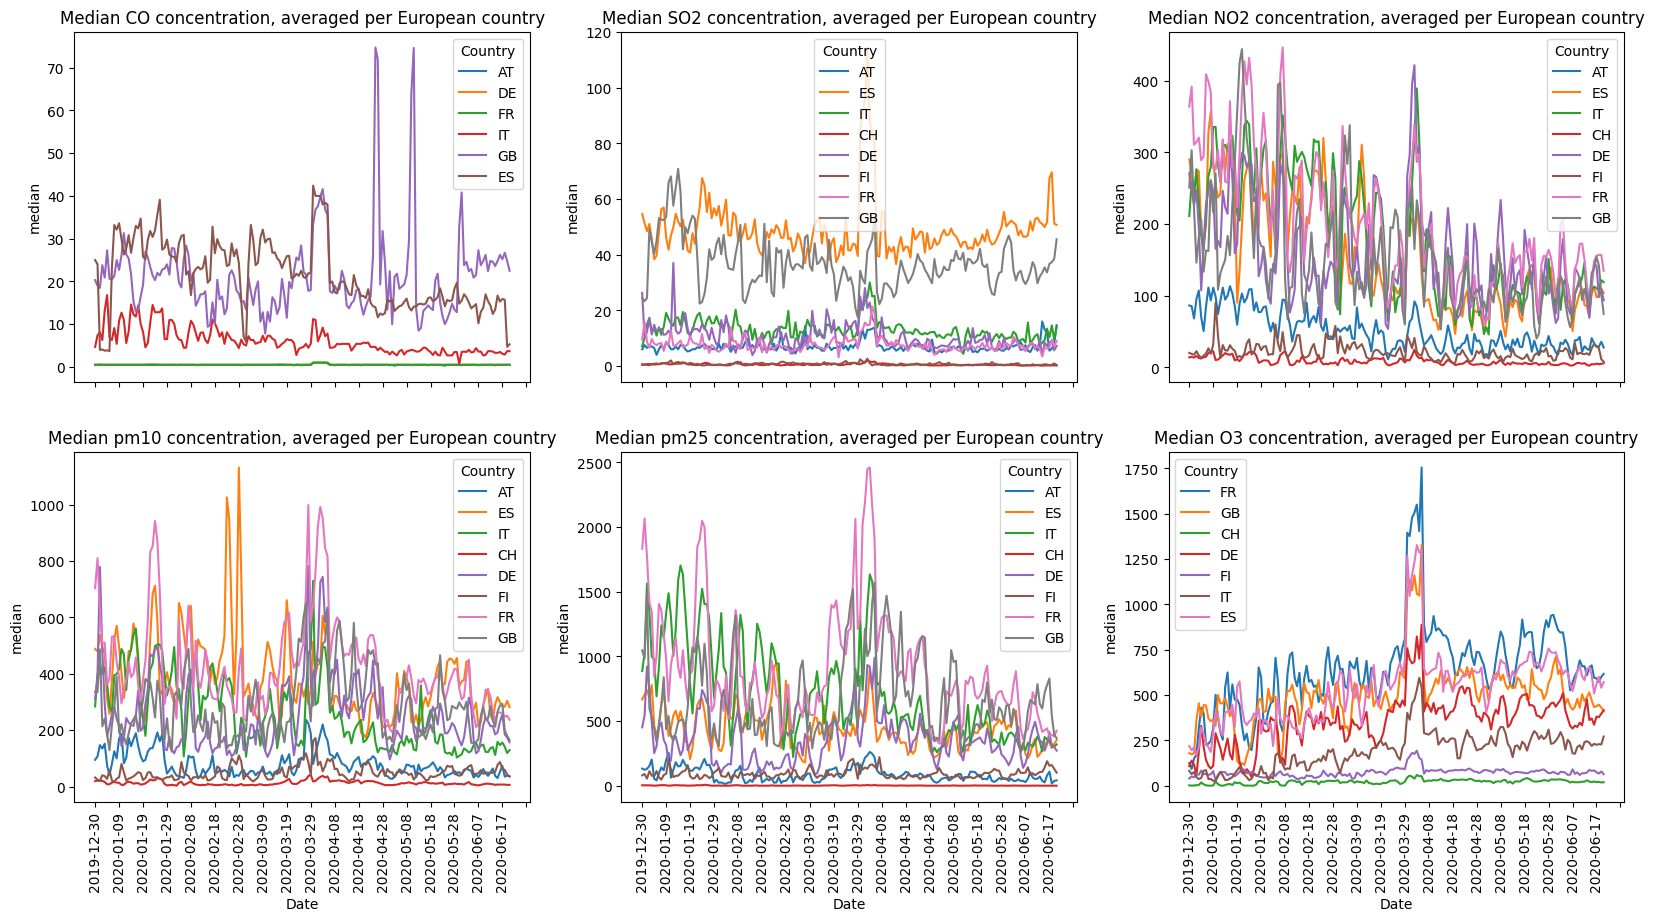

In [51]:
idx = pd.IndexSlice
fig,ax=plt.subplots(2,3,figsize=(20,10), sharex=True)

sns.lineplot(data = air_quality_df_average.loc[idx[['AT','FR','DE','IT','ES','GB','CH','FI'],'co','2019-12-30':'2020-06-20'], :].sort_values(by='Date'),
             x='Date', y='median',hue='Country', ax=ax[0][0])
ax[0][0].tick_params(axis='x',rotation=90)
ax[0][0].xaxis.set_major_locator(plt.MaxNLocator(20))
ax[0][0].set_title('Median CO concentration, averaged per European country')


sns.lineplot(data = air_quality_df_average.loc[idx[['AT','FR','DE','IT','ES','GB','CH','FI'],'so2','2019-12-30':'2020-06-20'],:].sort_values(by='Date'), 
             x='Date', y='median',hue='Country', ax=ax[0][1])
ax[0][1].tick_params(axis='x',rotation=90)
ax[0][1].xaxis.set_major_locator(plt.MaxNLocator(20))
ax[0][1].set_title('Median SO2 concentration, averaged per European country')

sns.lineplot(data = air_quality_df_average.loc[idx[['AT','FR','DE','IT','ES','GB','CH','FI'],'no2','2019-12-30':'2020-06-20'], :].sort_values(by='Date'),
             x='Date', y='median',hue='Country', ax=ax[0][2])
ax[0][2].tick_params(axis='x',rotation=90)
ax[0][2].xaxis.set_major_locator(plt.MaxNLocator(20))
ax[0][2].set_title('Median NO2 concentration, averaged per European country')

sns.lineplot(data = air_quality_df_average.loc[idx[['AT','FR','DE','IT','ES','GB','CH','FI'],'pm10','2019-12-30':'2020-06-20'], :].sort_values(by='Date'),
             x='Date', y='median',hue='Country', ax=ax[1][0])
ax[1][0].tick_params(axis='x',rotation=90)
ax[1][0].xaxis.set_major_locator(plt.MaxNLocator(20))
ax[1][0].set_title('Median pm10 concentration, averaged per European country')


sns.lineplot(data = air_quality_df_average.loc[idx[['AT','FR','DE','IT','ES','GB','CH','FI'],'pm25','2019-12-30':'2020-06-20'], :].sort_values(by='Date'),
             x='Date', y='median',hue='Country', ax=ax[1][1])
ax[1][1].tick_params(axis='x',rotation=90)
ax[1][1].xaxis.set_major_locator(plt.MaxNLocator(20))
ax[1][1].set_title('Median pm25 concentration, averaged per European country')

sns.lineplot(data = air_quality_df_average.loc[idx[['AT','FR','DE','IT','ES','GB','CH','FI'],'o3','2019-12-30':'2020-06-20'], :].sort_values(by='Date'),
             x='Date', y='median',hue='Country', ax=ax[1][2])
ax[1][2].tick_params(axis='x',rotation=90)
ax[1][2].xaxis.set_major_locator(plt.MaxNLocator(20))
ax[1][2].set_title('Median O3 concentration, averaged per European country')

plt.show()

We can globally see a decrease in the polluting particles during the covid period, we could later try to see if there is a correlation with the better air quality and interest in the climate change

# General demographics
## Covid cases demographics

It might be interesting to observe the link between number of deaths / cases of covid in country with the level of mobility restriction and finally with the level of interest/disinterest from the climate change topics. For this we need the general demographics of the covid cases, available from [Our World in data (WHO)](https://ourworldindata.org/covid-cases)

In [52]:
covid_cases_data = pd.read_csv(COVID_CASES_GZ,compression='gzip',low_memory=False)
covid_cases_data.head()

iso_code continent     location        date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan  2020-02-24          5.0        5.0   
1      AFG      Asia  Afghanistan  2020-02-25          5.0        0.0   
2      AFG      Asia  Afghanistan  2020-02-26          5.0        0.0   
3      AFG      Asia  Afghanistan  2020-02-27          5.0        0.0   
4      AFG      Asia  Afghanistan  2020-02-28          5.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   male_smokers  handwashing_facilities  hospital_beds_per_thousand  \
0           NaN                  37.746                         0.5   
1           NaN                  37.746                         0.5   
2           NaN                  37.746                         0.5   
3           NaN                  37.746                         0.5   
4           NaN                  37.746                         0.5   

   life_expectancy  human_development_index  population  \
0            64.83                    0.511  41128772.0   
1            64.83                    0.511  41128772.0   
2            64.83                    0.511  41128772.0   
3            64.83                    0.511  41128772.0   
4            64.83                    0.511  41128772.0   

   excess_mortality_cumulative_absolute  excess_mortality_cumulative  \
0                                   NaN                          NaN   
1                                   NaN                          NaN   
2                                   NaN                          NaN   
3                                   NaN                          NaN   
4                                   NaN                          NaN   

   excess_mortality  excess_mortality_cumulative_per_million  
0               NaN                                      NaN  
1               NaN                                      NaN  
2               NaN                                      NaN  
3               NaN                                      NaN  
4               NaN                                      NaN  

[5 rows x 67 columns]

Text(0.5, 1.0, 'Number of cases deaths per million habitants smoothed')

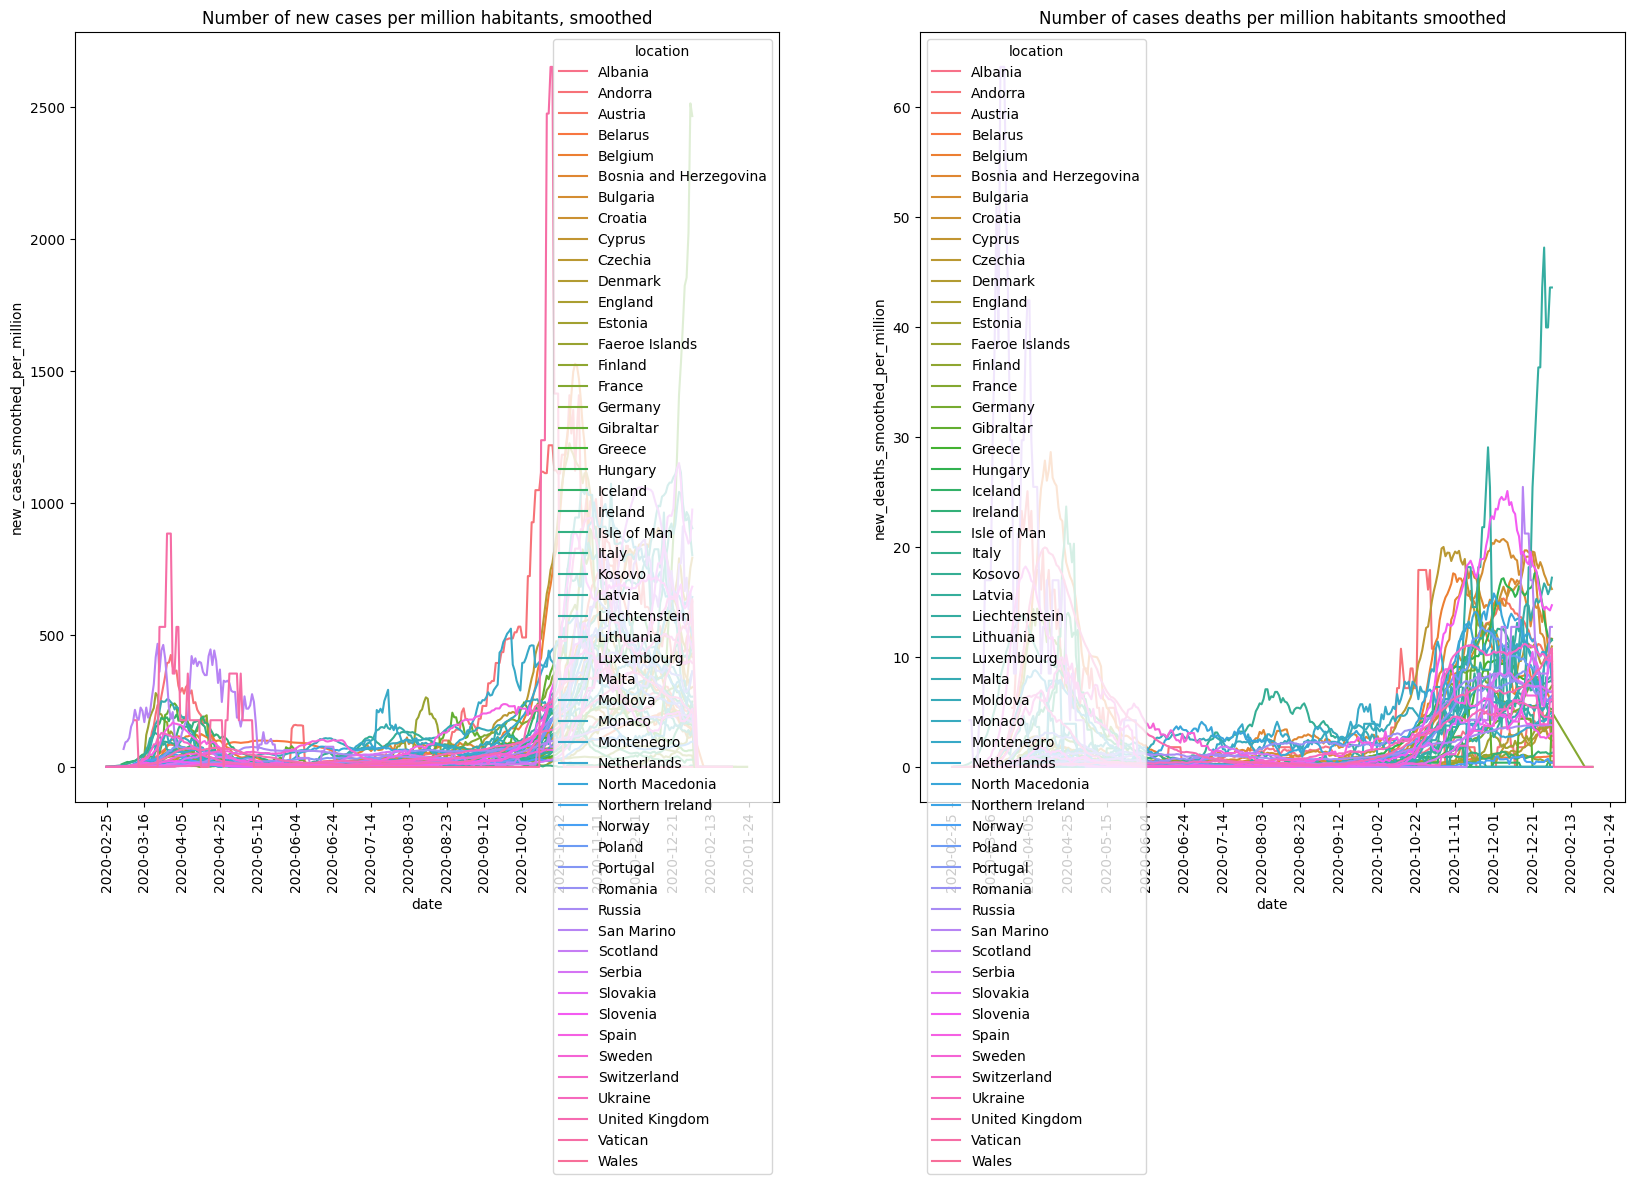

In [53]:
fig,ax=plt.subplots(1,2, figsize=(20,10))
sns.lineplot(data=covid_cases_data[(covid_cases_data.continent == 'Europe') & (covid_cases_data.date<'2021-01-01')],
             x='date', y='new_cases_smoothed_per_million', hue='location', ax=ax[0])
#plt.tick_params(labelrotation=90)
ax[0].tick_params(axis='x',rotation=90)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(20))
ax[0].set_title('Number of new cases per million habitants, smoothed')

sns.lineplot(data=covid_cases_data[(covid_cases_data.continent == 'Europe') & (covid_cases_data.date<'2021-01-01')],
             x='date', y='new_deaths_smoothed_per_million', hue='location',ax=ax[1])
ax[1].tick_params(axis='x',rotation=90)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(20))
ax[1].set_title('Number of cases deaths per million habitants smoothed')


# **Project pipeline**

Now that we have explored the available datasets plus some other data that we obtained independently, we will extract the informations and plots that we believe are the most relevant for our analyses. 

In this section, we will do a case example using one country/language, in order to show the feasibility of our idea. But the final project will be enriched with more countries/languages. For the final project, chosen countries will be only countries were the corresponding language is spoken nowhere else, in order to avoid wrong data in wikipedia searches, as this is based on language and not on country. For this case example pipeline, we will use Italy as country, with Italian being the corresponding language.

A first question that we would like to answer is: **How did the covid crisis impact people's lifestyle, their mobility and localization ?**

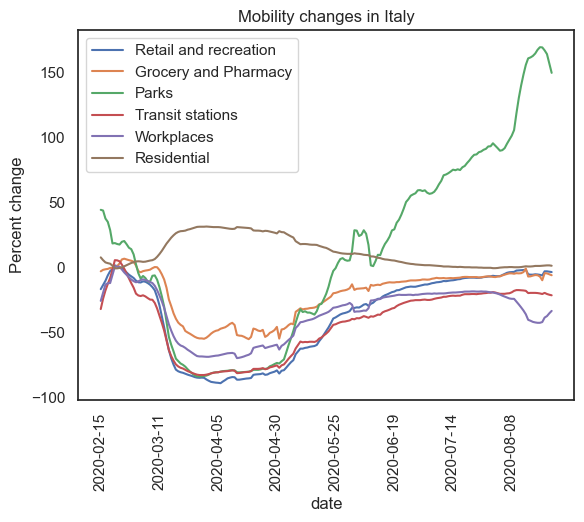

In [71]:
#Plotting for Italy
mean_globality_europe.loc['Italy',mean_globality_europe_percent_change_col_smoothed].plot()
plt.legend(['Retail and recreation','Grocery and Pharmacy','Parks','Transit stations','Workplaces','Residential'])
plt.xticks(rotation=90)
plt.ylabel('Percent change')
plt.title('Mobility changes in Italy')
plt.show()

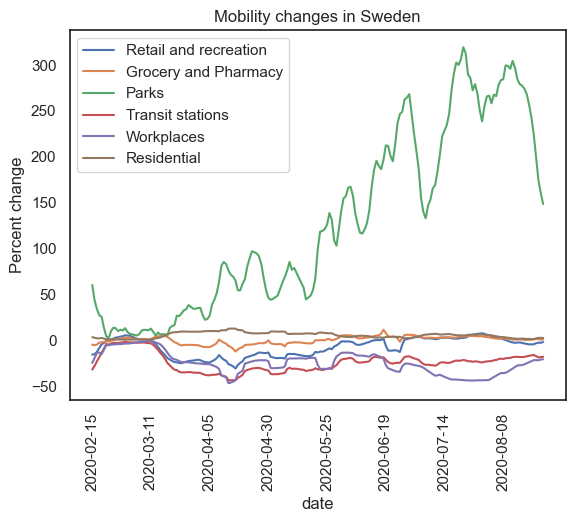

In [74]:
#Plotting for Italy
mean_globality_europe.loc['Sweden',mean_globality_europe_percent_change_col_smoothed].plot()
plt.legend(['Retail and recreation','Grocery and Pharmacy','Parks','Transit stations','Workplaces','Residential'])
plt.xticks(rotation=90)
plt.ylabel('Percent change')
plt.title('Mobility changes in Sweden')
plt.show()

This pattern, tough common to most countries during this period, can still vary depending of the different policies adopted by the respective government. This could allow to classify countries based on lockdown severity (see the impact factor below).

A second question that we would like to answer is: **Is this trend correlated with a higher number of overall google searches ?**

In [55]:
pytrend = TrendReq()

#provide your search terms
kw_list=['google']

#search interest per region
pytrend.build_payload(kw_list, timeframe='2018-01-01 2022-01-01', geo='IT')

#Interest over time
interest_over_time = pytrend.interest_over_time()
# Interest by Region
regiondf = pytrend.interest_by_region()
#looking at rows where all values are not equal to 0
regiondf = regiondf[(regiondf != 0).all(1)]
#drop all rows that have null values in all columns
regiondf.dropna(how='all',axis=0, inplace=True)
interest_over_time.dropna(how='all',axis=0, inplace=True)

#visualise
#regiondf.plot(figsize=(20, 12), y=kw_list, kind ='bar')
interest_over_time.plot(figsize=(10, 6))
plt.axvline('2020-01-16', ls=":", color="black", zorder=1, label = "first covid case")
plt.axvline('2020-02-23', ls="-", color="blue", zorder=1, label = "school closure")
plt.axvline('2020-03-11', ls="-", color="red", zorder=1, label = "lockdown")
plt.legend()

ResponseError: The request failed: Google returned a response with code 429.

Although it doesn't perfectly reflect the amount of all googles searches as this returns the amount of time the term 'google' was searched, we clearly observe a tendancy which is a big raise in searches during lockdown, and we can assume it reflects the overall number of searches.  

We also think that Google Trend data can approximate well the overall searches landscape, as it counts for 92% of all internet searches (source: https://fitsmallbusiness.com/google-search-statistics/)  

Now that we have observed a raise in Google searches, we then want to focus on a more specific subject. Our next question is thus:  
**Did interest for ecology change during the covid pandemic ?** 

To answer this question, we will look at both Google Trend and Wikipedia pageviews data.

In [ ]:
pytrend = TrendReq()

#provide your search terms
kw_list=['ecology', 'climate change', 'greenhouse']

#search interest per region
#run model for keywords (can also be competitors)
pytrend.build_payload(kw_list, timeframe='2019-01-01 2022-01-01', geo='IT')

#Interest over time
interest_over_time = pytrend.interest_over_time()
# Interest by Region
regiondf = pytrend.interest_by_region()
#looking at rows where all values are not equal to 0
regiondf = regiondf[(regiondf != 0).all(1)]
#drop all rows that have null values in all columns
regiondf.dropna(how='all',axis=0, inplace=True)
interest_over_time.dropna(how='all',axis=0, inplace=True)

#visualise
#regiondf.plot(figsize=(20, 12), y=kw_list, kind ='bar')
interest_over_time.plot(figsize=(10, 6))
plt.axvline('2020-01-16', ls=":", color="black", zorder=1, label = "first covid case")
plt.axvline('2020-02-23', ls="-", color="blue", zorder=1, label = "school closure")
plt.axvline('2020-03-11', ls="-", color="red", zorder=1, label = "lockdown")
plt.legend()

In [ ]:
climate_change_cat_it = 'data/added_data/massviews-it-20180101-20220101.csv'
climate_change_cat_it = pd.read_csv(climate_change_cat_it)
climate_change_cat_it = climate_change_cat_fr.append(climate_change_cat_it.sum(axis = 0), ignore_index = True)

In [ ]:
temp_df_it = climate_change_cat_it.iloc[climate_change_cat_it.shape[0]-1,1:].rolling(7).mean()

plt.axes().xaxis.set_major_locator(plt.MaxNLocator(10))
plt.plot(temp_df_it.index,temp_df_it.values)
plt.xticks(rotation = 90, fontsize=8)
plt.legend(['it', 'en'])
plt.ylabel('Number of views')
plt.xlabel(' Time ')
plt.title(' Cumulative number of views for articles in the Climate change category')
plt.axvline('2019-12-01', ls="-", color="red", zorder=1, label = "first covid case")
plt.legend()
plt.show()

We observe a clear trend showing that interest toward ecological subjects has fallen during lockdown on the global scale. But here for `Italy`, we see that the numbers of searches doesn't drop. But we need to compensate for the increase in total google searches. After addressing this issue, our next question will thus be:  
**How did the severity of lockdown in a country have an impact on the disinterest toward ecological topics ? (Does a more severe lockdown increases the observed trends ?)**

An idea would be to compute a metrics indicative of the restrictiveness of the lockdown in each country. To do so we can add or substract percent change in every category in absolute number. Categories can be labelled as having a positive or negative impact on lockdown measures. For instance, to have an idea of level of lockdown you would substract values of percent change in workplace, transit, retail and recreation station (which were the typically restricted area, thus high change in negative value would have high positive impact on the impact factor) and maybe add residential (if it is increased, the impact factor should be stronger) and maybe substract Parks and residential (if it is increased, it is a less strict lockdown, if it is deacreased it is a more strict lockdown). As everything is in percent change it already is in the same unit.

In [19]:
mean_globality_europe['lockdown_impact_factor'] = -mean_globality_europe['transit_stations_percent_change_from_baseline']-mean_globality_europe['workplaces_percent_change_from_baseline']-mean_globality_europe['retail_and_recreation_percent_change_from_baseline']+mean_globality_europe['residential_percent_change_from_baseline'] #+mean_globality_europe['parks_percent_change_from_baseline']
mean_globality_europe['lockdown_smooth'] = mean_globality_europe['lockdown_impact_factor'].rolling(7).mean()


As observed in the analysis part, it is important to use weekly smoothed data.

Text(0, 0.5, 'Impact factor')

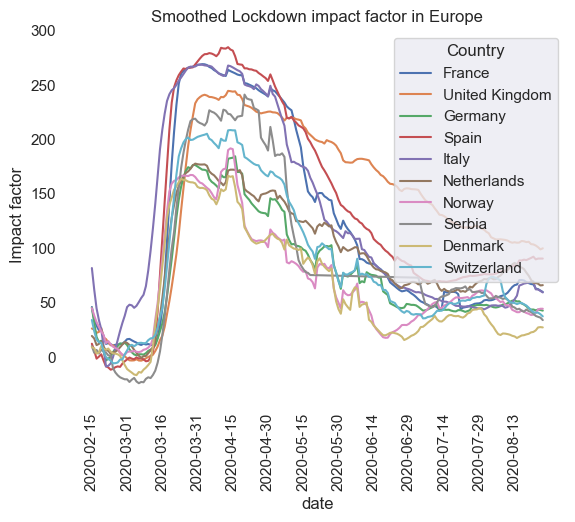

In [24]:
fig,ax=plt.subplots()
sns.set()
ax.set_facecolor('white')
ax=sns.lineplot(data = mean_globality_europe.loc[['France','United Kingdom','Germany','Spain','Italy','Netherlands','Norway','Serbia','Denmark', 'Switzerland']], 
                x ='date', y ='lockdown_smooth',hue = 'Country')
ax.tick_params(axis ='x',rotation = 90)
ax.xaxis.set_major_locator(plt.MaxNLocator(20))

ax.set_title('Smoothed Lockdown impact factor in Europe')
ax.set_ylabel('Impact factor')

Already in this graph you can see the difference between more strict politics such as France or Italy, and less restrictive politics such as the one in Sweden.  

Based on this we can expect the attitude towards climate change to be impacted differently in different countries

An interesting thing would be to further dissect the global trend observed of disinterest in the climate crisis into more detail. The question we would like to answer would thus be:  
**Which subjects within the theme of climate change gained or lost popularity during the lockdown period ?**

An idea would be to create the kind of plot shown below, which was presented in the paper linked to our dataset. We would in our case compare the number of visit for articles linked to ecology before, during, and after lockdown. For this we would probably compare three periods, a baseline between 2018 or 2019 and the beginning of the pandemic (we can consider it until February 2020), a lockdown period (March 2020 - May 2020) and then a new baseline during the summer 2020 (June-August 2020) during which most restrictions were lifted and covid cases were quite low.  

Statistic tests will be useful to check wheather the change is significant or not.

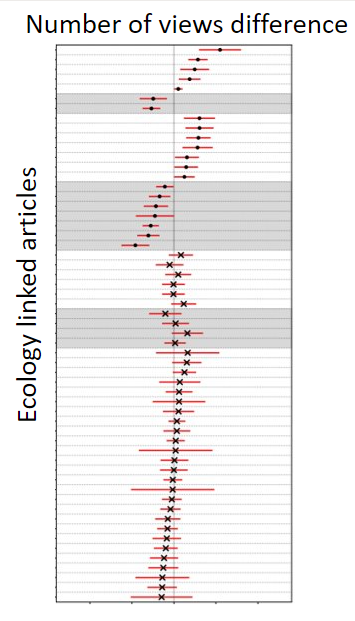

We would additionnally present a graph such as the one shown below (numbers would be mean number of clicks for this category during this time period):

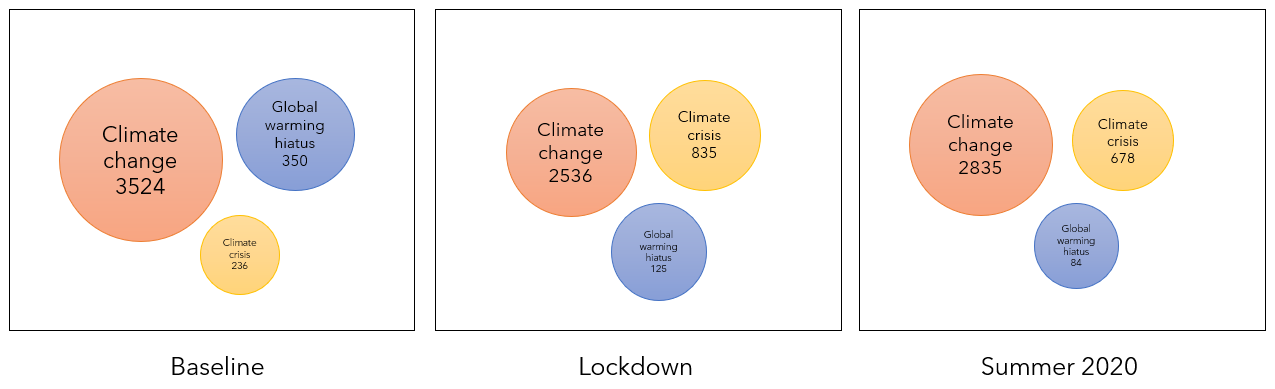

Finally based on which subjects interest people to most, we would like to sort them into 2 categories according to the interest people have toward the article (higher or no change in interest versus loss of interest). With these informations, we might be able to answer the following question:  

**How to maintain awarness on the ecological questions during a world crisis ? and propose some guidelines on how to do it.**

### Possible developments / openings

If time and ressources allow, we also have 3 ideas that could be interesting to investigate:  
* Check if the change of attitude towards the climate crisis has consequences on the number of page views for related articles in other topics (related to politics, religion, education, etc.)  
* Compare the content of two categories of articles (subject linked to global problems vs subjects linked to more local problems) and see if people are less interested in things that are far away from them in time.
* The datasets presented in the [Global air quality data](#Global-air-quality-data) and [Covid cases demographics](#Covid-cases-demographics) can be used to further analyze respectively, how did the air quality actually improved during the pandemic, and how populations were affected by the crisis in terms of cases and deaths, in both cases how it can relate to ecological concern changes.

---
## Test

Separate the dataset in 3 time periods, before, during and after(summer) the pandemic, and for each, we take the top 10 of subjects. We create a new dataframe with the average during this period of the number of pageviews and the title of the article, and make sure they are in ascending order

In [253]:
climate_change_cat_baseline = pd.DataFrame(climate_change_cat.set_index('Title').loc[:,'2018-01-01':'2020-01-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:].nlargest(20,'Average')
climate_change_cat_covid =  pd.DataFrame(climate_change_cat.set_index('Title').loc[:,'2020-01-01':'2020-05-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:].nlargest(20,'Average')
climate_change_cat_summer = pd.DataFrame(climate_change_cat.set_index('Title').loc[:,'2020-05-01':'2020-09-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:].nlargest(20,'Average')

climate_change_cat_baseline = climate_change_cat_baseline.sort_values(ascending= True, by = 'Average').copy()
climate_change_cat_covid = climate_change_cat_covid.sort_values(ascending= True, by = 'Average').copy()
climate_change_cat_summer = climate_change_cat_summer.sort_values(ascending= True, by = 'Average').copy()


In [63]:
climate_change_cat_baseline

Title      Average
10                    Infrared window    82.020520
11              Abrupt climate change    89.153215
9               Global warming hiatus   102.454172
6           General circulation model   114.896033
5    Deforestation and climate change   143.950752
4                      Global dimming   181.098495
1   History of climate change science   442.236662
2                 Climate engineering   447.458276
3                      Global cooling   451.162791
0                      Climate change  4032.419973

In [64]:
'''import random
climate_change_cat_baseline['Y']=np.repeat([1,2,3], repeats = 4)
climate_change_cat_baseline['X']=np.tile([1,2,3,4], reps = 3)

climate_change_cat_covid['Y']=np.repeat([0.5,1.5,2.5], repeats = 4)
climate_change_cat_covid['X']=np.tile([0.5,1.5,2.5,3.5], reps = 3)

climate_change_cat_summer['Y']=np.repeat([1,2,3], repeats = 4)
climate_change_cat_summer['X']=np.tile([1,2,3,4], reps = 3)'''

"import random\nclimate_change_cat_baseline['Y']=np.repeat([1,2,3], repeats = 4)\nclimate_change_cat_baseline['X']=np.tile([1,2,3,4], reps = 3)\n\nclimate_change_cat_covid['Y']=np.repeat([0.5,1.5,2.5], repeats = 4)\nclimate_change_cat_covid['X']=np.tile([0.5,1.5,2.5,3.5], reps = 3)\n\nclimate_change_cat_summer['Y']=np.repeat([1,2,3], repeats = 4)\nclimate_change_cat_summer['X']=np.tile([1,2,3,4], reps = 3)"

In [69]:
''' fig, ax = plt.subplots()

sns.scatterplot(data=climate_change_cat_baseline, x='X', y= 'Y', size="Average", legend=False, sizes=(10,2000), label='Title')
rows, cols = climate_change_cat_baseline.shape
a = pd.concat({'x': climate_change_cat_baseline.X, 'y': climate_change_cat_baseline.Y, 'text': climate_change_cat_baseline.Title}, axis=1)
for i, point in a.iterrows():
    ax.text(point['x'], point['y']+0.15, str(point['text']),fontsize=6)
    
sns.scatterplot(data=climate_change_cat_covid, x='X', y= 'Y', size="Average", legend=False, sizes=(10,2000), label='Title')
rows, cols = climate_change_cat_covid.shape
a = pd.concat({'x': climate_change_cat_covid.X, 'y': climate_change_cat_covid.Y, 'text': climate_change_cat_covid.Title}, axis=1)
for i, point in a.iterrows():
    ax.text(point['x'], point['y']+0.15, str(point['text']),fontsize=6)
plt.xlim([-0.5,5])
plt.ylim([-0.5,3.5])
plt.show()
'''

' fig, ax = plt.subplots()\n\nsns.scatterplot(data=climate_change_cat_baseline, x=\'X\', y= \'Y\', size="Average", legend=False, sizes=(10,2000), label=\'Title\')\nrows, cols = climate_change_cat_baseline.shape\na = pd.concat({\'x\': climate_change_cat_baseline.X, \'y\': climate_change_cat_baseline.Y, \'text\': climate_change_cat_baseline.Title}, axis=1)\nfor i, point in a.iterrows():\n    ax.text(point[\'x\'], point[\'y\']+0.15, str(point[\'text\']),fontsize=6)\n    \nsns.scatterplot(data=climate_change_cat_covid, x=\'X\', y= \'Y\', size="Average", legend=False, sizes=(10,2000), label=\'Title\')\nrows, cols = climate_change_cat_covid.shape\na = pd.concat({\'x\': climate_change_cat_covid.X, \'y\': climate_change_cat_covid.Y, \'text\': climate_change_cat_covid.Title}, axis=1)\nfor i, point in a.iterrows():\n    ax.text(point[\'x\'], point[\'y\']+0.15, str(point[\'text\']),fontsize=6)\nplt.xlim([-0.5,5])\nplt.ylim([-0.5,3.5])\nplt.show()\n'

For each we can represent the pageviews as a bubble with the size representing the average pageviwes during this time

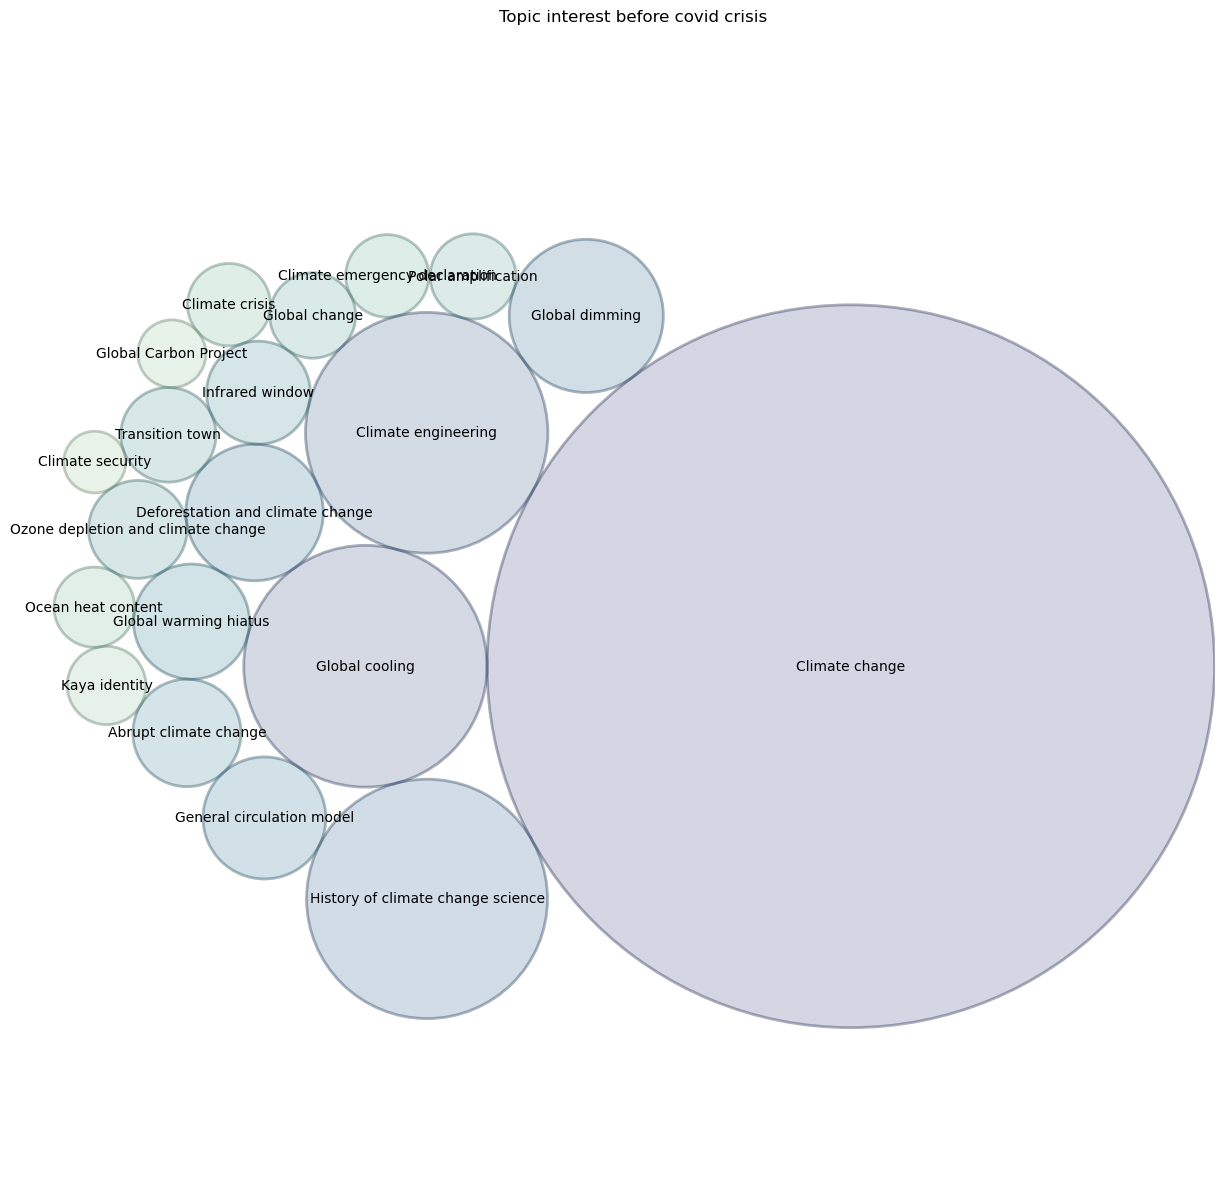

In [261]:
import circlify
import matplotlib.pyplot as plt

# compute circle positions:
circles = circlify.circlify(
    climate_change_cat_baseline['Average'].tolist(), 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(15,15))

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# print circles
for circle in circles:
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, fill=False))
    

# list of labels
labels = climate_change_cat_baseline['Title'] 

# print circles

palette = sns.color_palette("crest", 20)
colors = palette

for circle, label, color in zip(circles, labels,colors):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2,color= color))
    plt.annotate(
          label, 
          (x,y ) ,
          va='center',
          ha='center'
     )
    

plt.title('Topic interest before covid crisis')
plt.show()

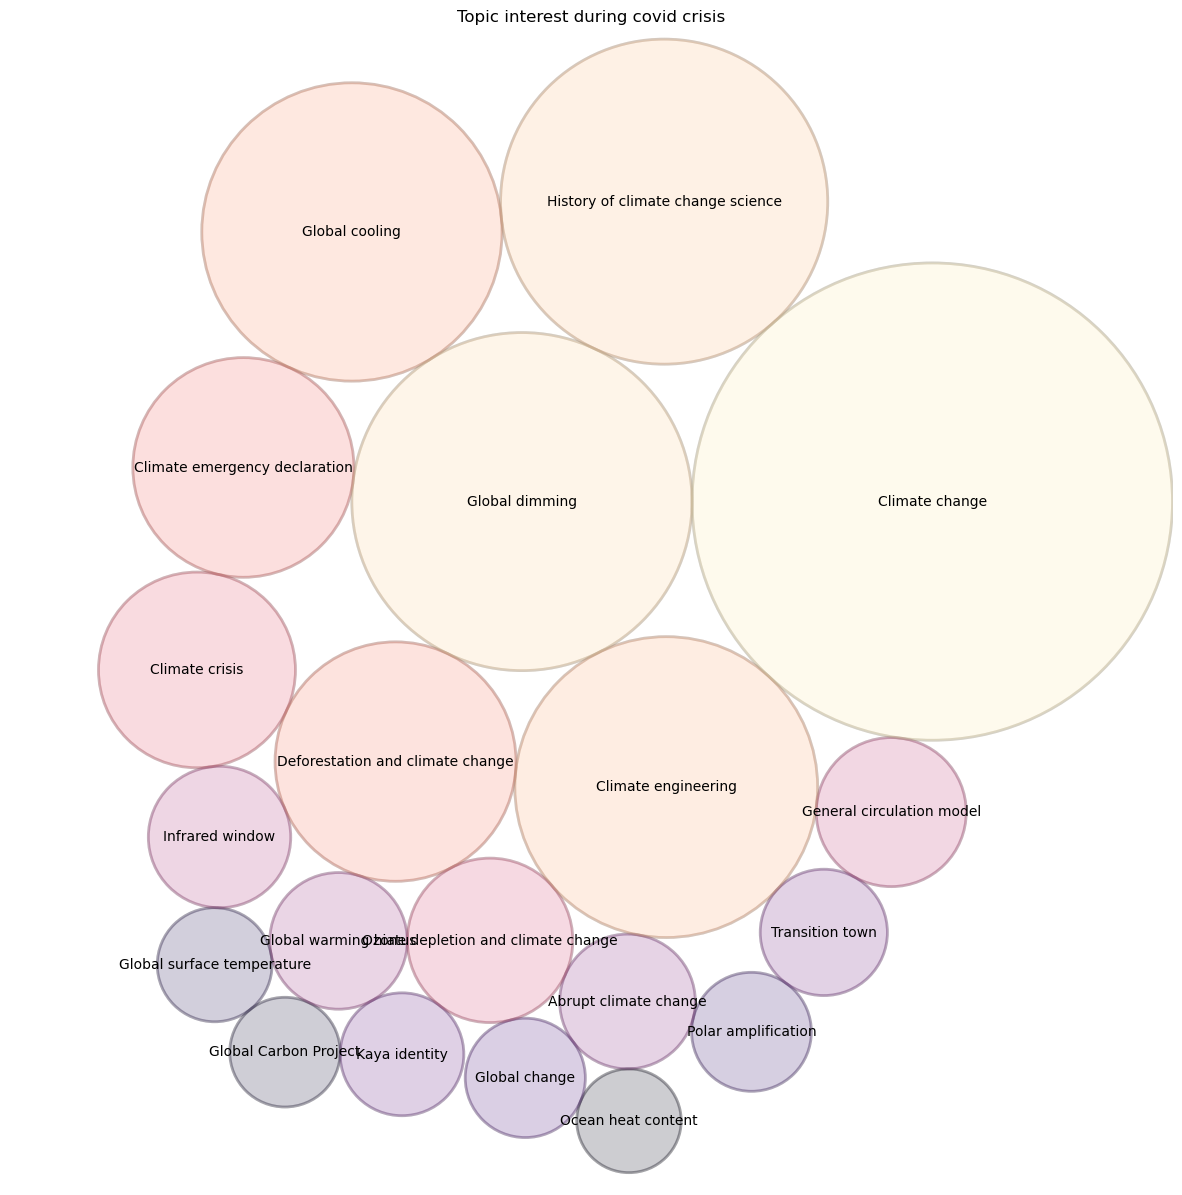

In [260]:
import circlify

# compute circle positions:
circles = circlify.circlify(
    climate_change_cat_covid['Average'].tolist(), 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(15,15))

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# print circles
import seaborn as sns
palette = sns.color_palette("magma", 20)
colors = palette
for circle in circles:
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, fill=False))
    

# list of labels
labels = climate_change_cat_covid['Title']

# print circles
for circle, label, color in zip(circles, labels,colors):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, color=color))
    plt.annotate(
          label, 
          (x,y ) ,
          va='center',
          ha='center'
     )
    
    
plt.title('Topic interest during covid crisis')
plt.show()

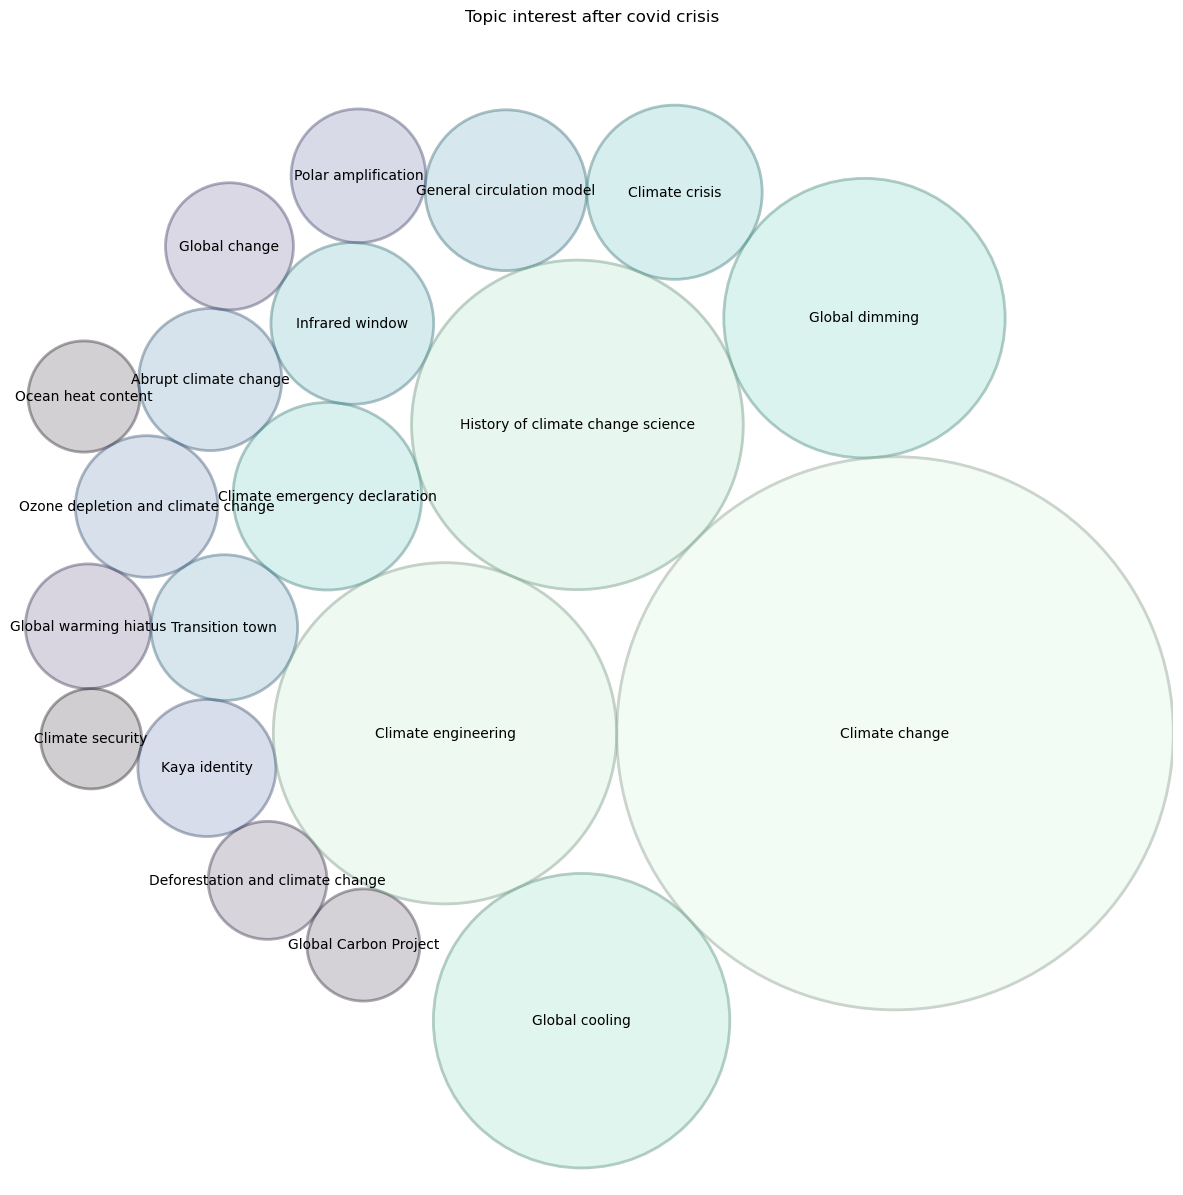

In [259]:
import circlify

# compute circle positions:
circles = circlify.circlify(
    climate_change_cat_summer['Average'].tolist(), 
    show_enclosure=False, 
    target_enclosure=circlify.Circle(x=0, y=0, r=1)
)

# Create just a figure and only one subplot
fig, ax = plt.subplots(figsize=(15,15))

# Remove axes
ax.axis('off')

# Find axis boundaries
lim = max(
    max(
        abs(circle.x) + circle.r,
        abs(circle.y) + circle.r,
    )
    for circle in circles
)
plt.xlim(-lim, lim)
plt.ylim(-lim, lim)

# print circles
import seaborn as sns
palette = sns.color_palette("mako", 20)
colors = palette
for circle in circles:
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, fill=False))
    

# list of labels
labels = climate_change_cat_summer['Title']

# print circles
for circle, label, color in zip(circles, labels,colors):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, alpha=0.2, linewidth=2, color=color))
    plt.annotate(
          label, 
          (x,y ) ,
          va='center',
          ha='center'
     )
    
    
plt.title('Topic interest after covid crisis')
plt.show()

---
Import the missing dataset for the Wikipedia article of the category 'Climate change' (in the corresponding languages)


In [42]:
climate_change_cat_it = 'data/added_data/massviews-20180101-20220101_it.csv'
climate_change_cat_it = pd.read_csv(climate_change_cat_it)
climate_change_cat_it = climate_change_cat_it.append(climate_change_cat_it.sum(axis=0),ignore_index=True)

climate_change_cat_no = 'data/added_data/massviews-20180101-20220101_no.csv'
climate_change_cat_no = pd.read_csv(climate_change_cat_no)
climate_change_cat_no = climate_change_cat_no.append(climate_change_cat_no.sum(axis=0),ignore_index=True)

climate_change_cat_da = 'data/added_data/massviews-20180101-20220101_da.csv'
climate_change_cat_da = pd.read_csv(climate_change_cat_da)
climate_change_cat_da = climate_change_cat_da.append(climate_change_cat_da.sum(axis=0),ignore_index=True)

climate_change_cat_nl = 'data/added_data/massviews-20180101-20220101_nl.csv'
climate_change_cat_nl = pd.read_csv(climate_change_cat_nl)
climate_change_cat_nl = climate_change_cat_nl.append(climate_change_cat_nl.sum(axis=0),ignore_index=True)

climate_change_cat_sr = 'data/added_data/massviews-20180101-20220101_sr.csv'
climate_change_cat_sr = pd.read_csv(climate_change_cat_sr)
climate_change_cat_sr = climate_change_cat_sr.append(climate_change_cat_sr.sum(axis=0),ignore_index=True)

C:\Users\Salomé\AppData\Local\Temp\ipykernel_22300\670633803.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  climate_change_cat_it = climate_change_cat_it.append(climate_change_cat_it.sum(axis=0),ignore_index=True)
C:\Users\Salomé\AppData\Local\Temp\ipykernel_22300\670633803.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  climate_change_cat_no = climate_change_cat_no.append(climate_change_cat_no.sum(axis=0),ignore_index=True)
C:\Users\Salomé\AppData\Local\Temp\ipykernel_22300\670633803.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  climate_change_cat_da = climate_change_cat_da.append(climate_change_cat_da.sum(axis=0),ignore_index=True)
C:\Users\Salomé\AppData\Local\Temp\ipykernel_22300\670633803.py:15: FutureW

We select the number of total pageviews of the related articles (exists by default in the last column of the dataframe) during the Lockdown period corresponding to each country (Time between Lockdown and Normalcy) and a period of the same duration before the Lockdown.

In [34]:
#Trying regression
from datetime import  timedelta
#summ of all the article views during the lockdown

#France
climate_pageviews_lockdown_fr_dist = climate_change_cat_fr.loc[:,interventions.loc['Lockdown','fr'].strftime('%Y-%m-%d') : interventions.loc['Normalcy','fr'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_lockdown_fr =climate_pageviews_lockdown_fr_dist.mean(axis=1).values[0]
#Do the logfold change on the same number of days before
date=interventions.loc['Lockdown','fr']-(interventions.loc['Normalcy','fr']-interventions.loc['Lockdown','fr'])
climate_pageviews_previous_fr_dist = climate_change_cat_fr.loc[:,  date.strftime('%Y-%m-%d'): interventions.loc['Lockdown','fr'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_previous_fr = climate_pageviews_previous_fr_dist.mean(axis=1).values[0]

#Deutschland
climate_pageviews_lockdown_de_dist= climate_change_cat_de.loc[:,interventions.loc['Lockdown','de'].strftime('%Y-%m-%d') : interventions.loc['Normalcy','de'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_lockdown_de = climate_pageviews_lockdown_de_dist.mean(axis=1).values[0]

#Do the logfold change on the same number of days before
date=interventions.loc['Lockdown','de']-(interventions.loc['Normalcy','de']-interventions.loc['Lockdown','de'])
#Take the same number of days
climate_pageviews_previous_de_dist = climate_change_cat_de.loc[:,  date.strftime('%Y-%m-%d'): interventions.loc['Lockdown','de'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_previous_de = climate_pageviews_previous_de_dist.mean(axis=1).values[0]


#Italy
climate_pageviews_lockdown_it_dist = climate_change_cat_it.loc[:,interventions.loc['Lockdown','it'].strftime('%Y-%m-%d') : interventions.loc['Normalcy','it'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_lockdown_it =climate_pageviews_lockdown_it_dist.mean(axis=1).values[0]
#Do the logfold change on the same number of days before
date=interventions.loc['Lockdown','it']-(interventions.loc['Normalcy','it']-interventions.loc['Lockdown','it'])
climate_pageviews_previous_it_dist = climate_change_cat_it.loc[:,  date.strftime('%Y-%m-%d'): interventions.loc['Lockdown','it'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_previous_it = climate_pageviews_previous_it_dist.mean(axis=1).values[0]

#Norway
climate_pageviews_lockdown_no_dist = climate_change_cat_no.loc[:,interventions.loc['Lockdown','no'].strftime('%Y-%m-%d') : interventions.loc['Normalcy','no'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_lockdown_no =climate_pageviews_lockdown_no_dist.mean(axis=1).values[0]

#Do the logfold change on the same number of days before
date=interventions.loc['Lockdown','no']-(interventions.loc['Normalcy','no']-interventions.loc['Lockdown','no'])
climate_pageviews_previous_no_dist = climate_change_cat_no.loc[:,  date.strftime('%Y-%m-%d'): interventions.loc['Lockdown','no'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_previous_no = climate_pageviews_previous_no_dist.mean(axis=1).values[0]

#Danemark
climate_pageviews_lockdown_da_dist = climate_change_cat_da.loc[:,interventions.loc['Lockdown','da'].strftime('%Y-%m-%d') : interventions.loc['Normalcy','da'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_lockdown_da =climate_pageviews_lockdown_da_dist.mean(axis=1).values[0]
#Do the logfold change on the same number of days before
date=interventions.loc['Lockdown','da']-(interventions.loc['Normalcy','da']-interventions.loc['Lockdown','da'])
climate_pageviews_previous_da_dist = climate_change_cat_da.loc[:,  date.strftime('%Y-%m-%d'): interventions.loc['Lockdown','da'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_previous_da = climate_pageviews_previous_da_dist.mean(axis=1).values[0]

#Nederlands
climate_pageviews_lockdown_nl_dist = climate_change_cat_nl.loc[:,interventions.loc['Lockdown','nl'].strftime('%Y-%m-%d') : interventions.loc['Normalcy','nl'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_lockdown_nl =climate_pageviews_lockdown_nl_dist.mean(axis=1).values[0]
#Do the logfold change on the same number of days before
date=interventions.loc['Lockdown','nl']-(interventions.loc['Normalcy','nl']-interventions.loc['Lockdown','nl'])
climate_pageviews_previous_nl_dist = climate_change_cat_nl.loc[:,  date.strftime('%Y-%m-%d'): interventions.loc['Lockdown','nl'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_previous_nl = climate_pageviews_previous_nl_dist.mean(axis=1).values[0]

#Serbia
climate_pageviews_lockdown_sr_dist = climate_change_cat_sr.loc[:,interventions.loc['Lockdown','sr'].strftime('%Y-%m-%d') : interventions.loc['Normalcy','sr'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_lockdown_sr =climate_pageviews_lockdown_sr_dist.mean(axis=1).values[0]
#Do the logfold change on the same number of days before
date=interventions.loc['Lockdown','sr']-(interventions.loc['Normalcy','sr']-interventions.loc['Lockdown','sr'])
climate_pageviews_previous_sr_dist = climate_change_cat_sr.loc[:,  date.strftime('%Y-%m-%d'): interventions.loc['Lockdown','sr'].strftime('%Y-%m-%d')].iloc[-1:]
climate_pageviews_previous_sr = climate_pageviews_previous_sr_dist.mean(axis=1).values[0]



In [35]:
country = ['France','Germany','Italy','Norway','Denmark','Netherlands','Serbia']
country_id = ['fr','de','it','no','da','nl','sr']

Then we can see the overall trend in pageviews across countries

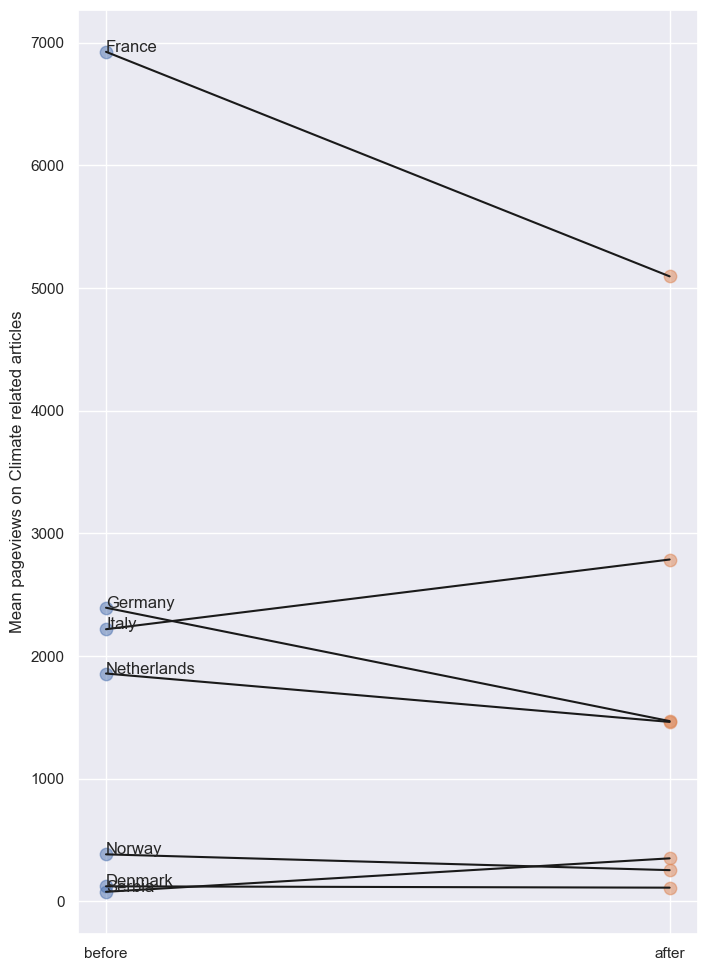

In [39]:


befores=  [climate_pageviews_previous_fr, climate_pageviews_previous_de, climate_pageviews_previous_it,climate_pageviews_previous_no,climate_pageviews_previous_da,climate_pageviews_previous_nl, climate_pageviews_previous_sr]
afters= [climate_pageviews_lockdown_fr,climate_pageviews_lockdown_de, climate_pageviews_lockdown_it,climate_pageviews_lockdown_no,climate_pageviews_lockdown_da,climate_pageviews_lockdown_nl, climate_pageviews_lockdown_sr]
# plotting the points
plt.figure(figsize=(8, 12))

plt.scatter(np.zeros(len(befores)),befores,s=80, alpha = 0.5)
plt.scatter(np.ones(len(afters)),afters,s=80, alpha = 0.5)

# plotting the lines
for i in range(len(befores)):
    plt.plot( [0,1], [befores[i], afters[i]], c='k')
    plt.text( 0, befores[i]+0.5, country[i])

plt.xticks([0,1], ['before', 'after'])
plt.ylabel('Mean pageviews on Climate related articles')
plt.show()

We can then test if the distribution of the pageviews before is the same as during. The test is done separately for each country

In [ ]:
#indep t-test Fr
t_ind, p_ind = stats.ttest_ind(a = climate_pageviews_lockdown_fr_dist.values, b = climate_pageviews_previous_fr_dist.values,axis=1)


In [ ]:
p_ind

In [ ]:
#indep t-test De
t_ind, p_ind = stats.ttest_ind(a = climate_pageviews_lockdown_de_dist.values, b = climate_pageviews_previous_de_dist.values,axis=1)


In [ ]:
p_ind

In [ ]:
#indep t-test Italy
t_ind, p_ind = stats.ttest_ind(a = climate_pageviews_lockdown_it_dist.values, b = climate_pageviews_previous_it_dist.values,axis=1)
p_ind

In [ ]:
#indep t-test Norway
t_ind, p_ind = stats.ttest_ind(a = climate_pageviews_lockdown_no_dist.values, b = climate_pageviews_previous_no_dist.values,axis=1)
p_ind

In [ ]:
#indep t-test Danemark
t_ind, p_ind = stats.ttest_ind(a = climate_pageviews_lockdown_da_dist.values, b = climate_pageviews_previous_da_dist.values,axis=1)
p_ind

In [ ]:
#indep t-test Nederlands
t_ind, p_ind = stats.ttest_ind(a = climate_pageviews_lockdown_nl_dist.values, b = climate_pageviews_previous_nl_dist.values,axis=1)
p_ind

In [ ]:
#indep t-test serbia
t_ind, p_ind = stats.ttest_ind(a = climate_pageviews_lockdown_sr_dist.values, b = climate_pageviews_previous_sr_dist.values,axis=1)
p_ind

Is there a link between the impact factor and mean change?

We can compute a summary of the impact factor metric by summing to have the global effect

In [23]:
country_rating = mean_globality_europe.groupby('Country')['lockdown_impact_factor'].sum().sort_values(ascending=False)[country]
country_rating

Country
France         22856.0
Germany        14803.0
Italy          24066.0
Norway         13692.0
Denmark        12036.0
Netherlands    17899.0
Serbia         14019.0
Name: lockdown_impact_factor, dtype: float64

In [ ]:
 interventions.loc['Normalcy',country]

- Try to find a way to extract the number of death corresponding to the normalcy date in each country-

In [40]:
covid_cases_data[covid_cases_data['location'].isin(country)][['location','date','total_cases']].groupby('location').last()

NameError: name 'covid_cases_data' is not defined

In [ ]:
#number of deaths 

In [41]:
d = { 'impact_factor': pd.Series(country_rating), 'pageviews_before' : befores, 'pageviews_after' : afters}
regression_pageviews =pd.DataFrame(data =d)
regression_pageviews

impact_factor  pageviews_before  pageviews_after
Country                                                      
France             22856.0       6924.342593      5093.953704
Germany            14803.0       2393.153153      1468.954955
Italy              24066.0       2217.861111      2786.111111
Norway             13692.0        382.945205       254.123288
Denmark            12036.0        122.362500       111.362500
Netherlands        17899.0       1856.838235      1462.294118
Serbia             14019.0         77.581395       350.279070

In [42]:
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [43]:
mod = smf.ols(formula='pageviews_after ~ impact_factor + pageviews_before', data=regression_pageviews)

In [44]:
np.random.seed(2)
res = mod.fit()

In [45]:
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        pageviews_after   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.992
Method:                 Least Squares   F-statistic:                     356.1
Date:                Mon, 12 Dec 2022   Prob (F-statistic):           3.12e-05
Time:                        20:13:57   Log-Likelihood:                -43.666
No. Observations:                   7   AIC:                             93.33
Df Residuals:                       4   BIC:                             93.17
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept        -1748.6047    305.998  

C:\ProgramData\Anaconda3\envs\ada\lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


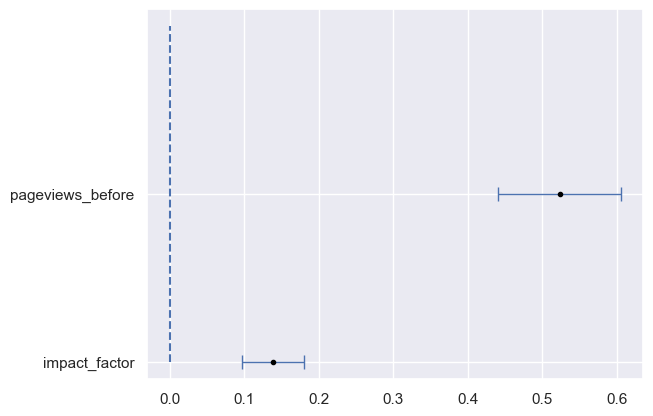

In [47]:
# feature names
variables = res.params.index

# quantifying uncertainty!

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#confidence intervals
res.conf_int()

l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

plt.errorbar(l1, np.array(range(len(l1))), xerr= 2*np.array(l3), linewidth = 1,
             linestyle = 'none',marker = 'o',markersize= 3,
             markerfacecolor = 'black',markeredgecolor = 'black', capsize= 5)

plt.vlines(0,0, len(l1), linestyle = '--')

plt.yticks(range(len(l2)),l2);

---
### Test plot differences baseline-covid-summer

In [219]:
#Overall
climate_change_cat = 'data/added_data/massviews-20180101-20220101.csv'
climate_change_cat = pd.read_csv(climate_change_cat)
climate_change_cat = climate_change_cat.append(climate_change_cat.sum(axis=0),ignore_index=True)

#Will be used for country specific implementation
'''
#Per country
climate_change_cat_fr = 'data/added_data/massviews-fr-20180101-20220101.csv'
climate_change_cat_fr = pd.read_csv(climate_change_cat_fr)
climate_change_cat_fr = climate_change_cat_fr.append(climate_change_cat_fr.sum(axis=0),ignore_index=True)

climate_change_cat_de = 'data/added_data/massviews-de-20180101-20220101.csv'
climate_change_cat_de = pd.read_csv(climate_change_cat_de)
climate_change_cat_de = climate_change_cat_de.append(climate_change_cat_de.sum(axis=0),ignore_index=True)

climate_change_cat_it = 'data/added_data/massviews-20180101-20220101_it.csv'
climate_change_cat_it = pd.read_csv(climate_change_cat_it)
climate_change_cat_it = climate_change_cat_it.append(climate_change_cat_it.sum(axis=0),ignore_index=True)

climate_change_cat_no = 'data/added_data/massviews-20180101-20220101_no.csv'
climate_change_cat_no = pd.read_csv(climate_change_cat_no)
climate_change_cat_no = climate_change_cat_no.append(climate_change_cat_no.sum(axis=0),ignore_index=True)

climate_change_cat_da = 'data/added_data/massviews-20180101-20220101_da.csv'
climate_change_cat_da = pd.read_csv(climate_change_cat_da)
climate_change_cat_da = climate_change_cat_da.append(climate_change_cat_da.sum(axis=0),ignore_index=True)

climate_change_cat_nl = 'data/added_data/massviews-20180101-20220101_nl.csv'
climate_change_cat_nl = pd.read_csv(climate_change_cat_nl)
climate_change_cat_nl = climate_change_cat_nl.append(climate_change_cat_nl.sum(axis=0),ignore_index=True)

climate_change_cat_sr = 'data/added_data/massviews-20180101-20220101_sr.csv'
climate_change_cat_sr = pd.read_csv(climate_change_cat_sr)
climate_change_cat_sr = climate_change_cat_sr.append(climate_change_cat_sr.sum(axis=0),ignore_index=True)
'''

/tmp/ipykernel_120/259686346.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  climate_change_cat = climate_change_cat.append(climate_change_cat.sum(axis=0),ignore_index=True)


"\n#Per country\nclimate_change_cat_fr = 'data/added_data/massviews-fr-20180101-20220101.csv'\nclimate_change_cat_fr = pd.read_csv(climate_change_cat_fr)\nclimate_change_cat_fr = climate_change_cat_fr.append(climate_change_cat_fr.sum(axis=0),ignore_index=True)\n\nclimate_change_cat_de = 'data/added_data/massviews-de-20180101-20220101.csv'\nclimate_change_cat_de = pd.read_csv(climate_change_cat_de)\nclimate_change_cat_de = climate_change_cat_de.append(climate_change_cat_de.sum(axis=0),ignore_index=True)\n\nclimate_change_cat_it = 'data/added_data/massviews-20180101-20220101_it.csv'\nclimate_change_cat_it = pd.read_csv(climate_change_cat_it)\nclimate_change_cat_it = climate_change_cat_it.append(climate_change_cat_it.sum(axis=0),ignore_index=True)\n\nclimate_change_cat_no = 'data/added_data/massviews-20180101-20220101_no.csv'\nclimate_change_cat_no = pd.read_csv(climate_change_cat_no)\nclimate_change_cat_no = climate_change_cat_no.append(climate_change_cat_no.sum(axis=0),ignore_index=True

In [240]:
#prepare data for plotting
climate_change_cat_baseline = pd.DataFrame(climate_change_cat.set_index('Title').loc[:,'2018-01-01':'2020-01-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:]
climate_change_cat_covid =  pd.DataFrame(climate_change_cat.set_index('Title').loc[:,'2020-01-01':'2020-05-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:]
climate_change_cat_summer = pd.DataFrame(climate_change_cat.set_index('Title').loc[:,'2020-05-01':'2020-09-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:]

In [241]:
climate_change_complete =  pd.DataFrame(columns=['Article', 'Baseline', 'Covid', 'Summer', 'BC_diff', 'BS_diff', 'CS_diff'])
climate_change_complete.Article = climate_change_cat_baseline.Title
climate_change_complete.Baseline = climate_change_cat_baseline.Average
climate_change_complete.Covid = climate_change_cat_covid.Average
climate_change_complete.Summer = climate_change_cat_summer.Average

#Differences are computed in %
climate_change_complete.BC_diff = (climate_change_cat_covid.Average - climate_change_cat_baseline.Average)/climate_change_cat_baseline.Average
climate_change_complete.BS_diff = (climate_change_cat_summer.Average - climate_change_cat_baseline.Average)/climate_change_cat_baseline.Average
climate_change_complete.CS_diff = (climate_change_cat_summer.Average - climate_change_cat_covid.Average)/climate_change_cat_covid.Average

In [242]:
#Only select articles with a sufficient number of views
climate_change_complete = climate_change_complete[climate_change_complete['Baseline'] > 20]
climate_change_complete

Article     Baseline       Covid      Summer  \
0                       Climate change  4032.419973  987.286885  710.895161   
1    History of climate change science   442.236662  457.868852  252.338710   
2                  Climate engineering   447.458276  392.278689  270.540323   
3                       Global cooling   451.162791  385.721311  201.580645   
4                       Global dimming   181.098495  495.254098  181.604839   
5     Deforestation and climate change   143.950752  248.409836   32.354839   
6            General circulation model   114.896033   96.270492   60.088710   
7        Climate emergency declaration    52.611491  209.114754   81.701613   
8                       Climate crisis    52.413133  165.942623   70.508065   
9                Global warming hiatus   102.454172   80.918033   36.161290   
10                     Infrared window    82.020520   86.762295   60.758065   
11               Abrupt climate change    89.153215   78.721311   46.927419   
12  Ozone depletion and climate change    73.974008  117.188525   46.580645   
13                     Transition town    69.057456   69.172131   49.362903   
14                 Polar amplification    56.049248   61.352459   41.588710   
15                       Kaya identity    47.273598   65.418033   43.677419   
16                       Global change    56.227086   61.745902   37.548387   
17                  Ocean heat content    49.562244   46.688525   28.725806   
18               Global Carbon Project    35.351573   52.172131   29.258065   
19                    Climate security    29.333789   39.672131   23.362903   

     BC_diff   BS_diff   CS_diff  
0  -0.755163 -0.823705 -0.279951  
1   0.035348 -0.429403 -0.448884  
2  -0.123318 -0.395384 -0.310336  
3  -0.145051 -0.553198 -0.477393  
4   1.734722  0.002796 -0.633310  
5   0.725658 -0.775237 -0.869752  
6  -0.162108 -0.477017 -0.375835  
7   2.974697  0.552923 -0.609298  
8   2.166050  0.345237 -0.575106  
9  -0.210203 -0.647049 -0.553112  
10  0.057812 -0.259233 -0.299718  
11 -0.117011 -0.473632 -0.403879  
12  0.584185 -0.370311 -0.602515  
13  0.001661 -0.285191 -0.286376  
14  0.094617 -0.257997 -0.322135  
15  0.383818 -0.076072 -0.332334  
16  0.098152 -0.332201 -0.391889  
17 -0.057982 -0.420409 -0.384735  
18  0.475808 -0.172369 -0.439201  
19  0.352438 -0.203550 -0.411100

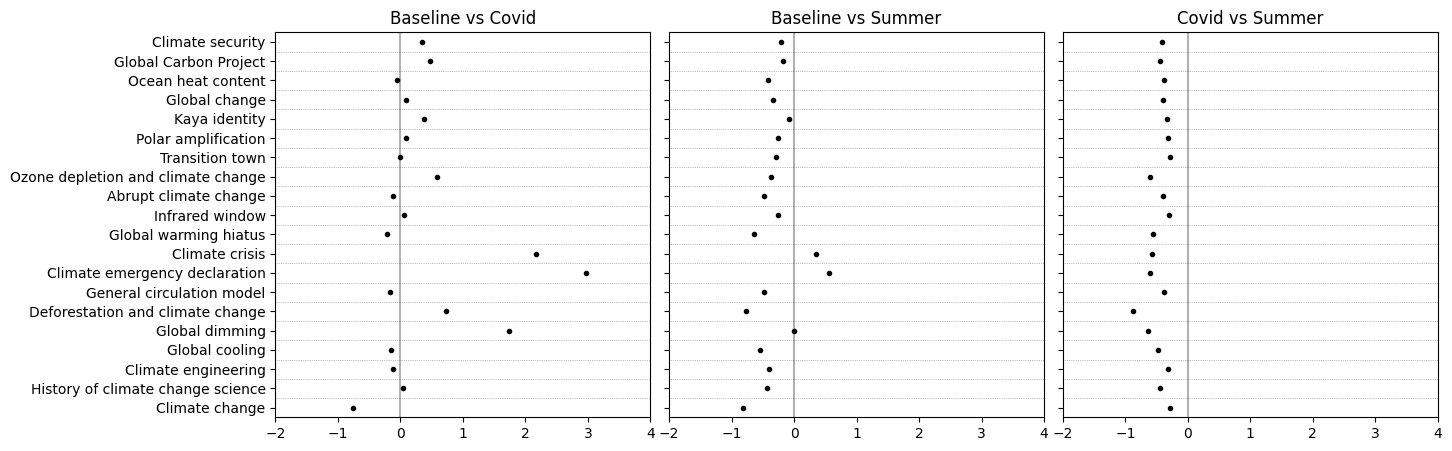

In [251]:
#Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True,
                       gridspec_kw={"hspace": 0.15, "wspace": 0.05})

for idx, article in enumerate(climate_change_complete['Article']):
    for idy, col in enumerate(["BC_diff", "BS_diff", "CS_diff"]):
        row = dict(climate_change_complete[climate_change_complete.Article == article].iloc[0])
        marker = "."
        #marker = "." if row["pval"] else "x"

        axes[idy].scatter([row[col]], [article], color="black", marker=marker, zorder=2)
        #axes[idy].plot([row["low"], row["high"]], [idx, idx], color="#e41a1c", zorder=1)
        axes[idy].axhline(idx+0.5, lw=0.5, ls=":", color='black', alpha=0.5)

    _ = axes[idy].set_yticks(range(0, idx+1))
    _ = axes[idy].set_ylim([-0.5,idx+0.5])
    _ = axes[idy].set_xlim([-2, 4])

for ax in axes:
    ax.axvline(0, zorder=0, color="black", ls="-", alpha=0.3)
    
axes[0].set_title("Baseline vs Covid")
axes[1].set_title("Baseline vs Summer")
axes[2].set_title("Covid vs Summer")
plt.show()

### Test for a specific country

In [255]:
#prepare data for plotting
climate_change_cat_baseline_fr = pd.DataFrame(climate_change_cat_fr.set_index('Title').loc[:,'2018-01-01':'2020-01-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:]
climate_change_cat_covid_fr =  pd.DataFrame(climate_change_cat_fr.set_index('Title').loc[:,'2020-01-01':'2020-05-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:]
climate_change_cat_summer_fr = pd.DataFrame(climate_change_cat_fr.set_index('Title').loc[:,'2020-05-01':'2020-09-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:]

In [256]:
climate_change_complete_fr =  pd.DataFrame(columns=['Article', 'Baseline', 'Covid', 'Summer', 'BC_diff', 'BS_diff', 'CS_diff'])
climate_change_complete_fr.Article = climate_change_cat_baseline_fr.Title
climate_change_complete_fr.Baseline = climate_change_cat_baseline_fr.Average
climate_change_complete_fr.Covid = climate_change_cat_covid_fr.Average
climate_change_complete_fr.Summer = climate_change_cat_summer_fr.Average

#Differences are computed in %
climate_change_complete_fr.BC_diff = (climate_change_cat_covid_fr.Average - climate_change_cat_baseline_fr.Average)/climate_change_cat_baseline_fr.Average
climate_change_complete_fr.BS_diff = (climate_change_cat_summer_fr.Average - climate_change_cat_baseline_fr.Average)/climate_change_cat_baseline_fr.Average
climate_change_complete_fr.CS_diff = (climate_change_cat_summer_fr.Average - climate_change_cat_covid_fr.Average)/climate_change_cat_covid_fr.Average

In [257]:
#Only select articles with a sufficient number of views
climate_change_complete_fr = climate_change_complete_fr[climate_change_complete_fr['Baseline'] > 20]
climate_change_complete_fr

Article     Baseline  \
0                            Réchauffement climatique  1150.838577   
1                       Accord de Paris sur le climat   352.380301   
2   Groupe d'experts intergouvernemental sur l'évo...   339.351573   
3                                        Anthropocène   315.313269   
4                                  Protocole de Kyoto   306.043776   
5                       Élévation du niveau de la mer   226.774282   
6                                         Gulf Stream   221.473324   
7                                          Bioéthanol   211.269494   
8                                        Biocarburant   176.813953   
9   Liste des pays par émissions de dioxyde de car...   150.953488   
10                           Extinction Permien-Trias   102.986320   
11                                 Sommet de la Terre   120.735978   
12  Convention-cadre des Nations unies sur les cha...   101.381669   
13                           Paramètres de Milanković    83.972640   
14                                      Bilan carbone    76.733242   
15  Risques d'effondrements environnementaux et so...    31.474692   
16                                 Neutralité carbone    44.777018   
17                                Petit âge glaciaire    40.021888   
18      Notre maison brûle et nous regardons ailleurs    69.016416   
19                                  The Shift Project    29.287278   
20                                  Constante solaire    53.186047   
21                  Potentiel de réchauffement global    49.529412   
22                                     Équivalent CO2    37.564979   
24                Adaptation au changement climatique    45.626539   
25                                       Scénario RCP    26.893297   
26                                 Hydrate de méthane    39.908345   
27                                 Réfugié écologique    37.161423   
28                                Limites planétaires    23.734610   
29                               Ozone troposphérique    33.682627   
30                             Îlot de chaleur urbain    36.028728   
31                Plan climat-air-énergie territorial    29.294118   
32                             Extinction du Dévonien    29.224350   
33                          Fonds vert pour le climat    34.533516   
34                         Consommation collaborative    34.983584   
35                                         Earth Hour    24.627907   
37        Liste des signataires du protocole de Kyoto    25.752394   
38                              Paquet climat-énergie    22.478796   
39         L'Affaire du siècle (campagne associative)    30.979480   
42                                 Milutin Milanković    20.309166   
44   Incident des courriels du Climatic Research Unit    22.041040   

          Covid      Summer   BC_diff   BS_diff   CS_diff  
0   1215.934426  527.870968  0.056564 -0.541316 -0.565872  
1    359.450820  220.411290  0.020065 -0.374507 -0.386811  
2    327.655738  179.467742 -0.034465 -0.471145 -0.452267  
3    438.540984  328.717742  0.390810  0.042512 -0.250429  
4    308.729508  173.500000  0.008776 -0.433088 -0.438019  
5    276.639344  182.153226  0.219889 -0.196764 -0.341550  
6    207.483607  179.177419 -0.063167 -0.190975 -0.136426  
7    207.139344  120.161290 -0.019549 -0.431242 -0.419901  
8    187.188525  108.250000  0.058675 -0.387775 -0.421706  
9    172.540984  101.072581  0.143008 -0.330439 -0.414211  
10   148.745902  126.830645  0.444327  0.231529 -0.147334  
11   122.237705   79.967742  0.012438 -0.337664 -0.345801  
12   112.942623   64.427419  0.114034 -0.364506 -0.429556  
13   102.459016   61.911290  0.220148 -0.262721 -0.395746  
14    81.852459   48.491935  0.066714 -0.368045 -0.407569  
15   214.434426  106.209677  5.812916  2.374447 -0.504699  
16    75.827869   55.975806  0.693455  0.250101 -0.261804  
17    38.934426   31.758065 -0.027172 -0.206483 -0.184319  
18    59.803279   42.637097 -0.1334

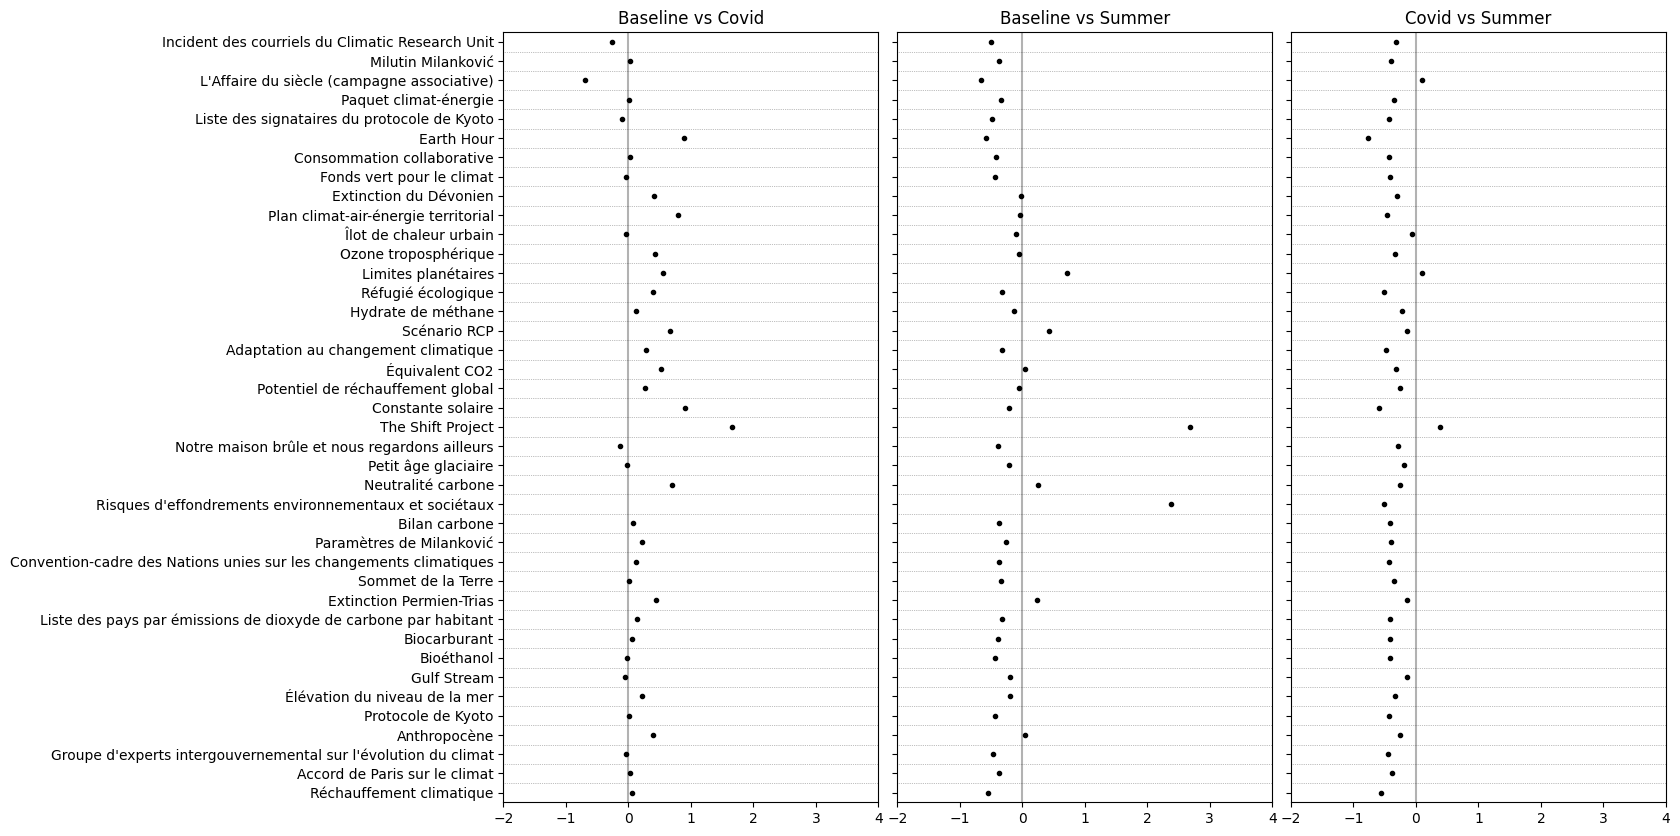

In [260]:
#Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True, sharex=True,
                       gridspec_kw={"hspace": 0.15, "wspace": 0.05})

for idx, article in enumerate(climate_change_complete_fr['Article']):
    for idy, col in enumerate(["BC_diff", "BS_diff", "CS_diff"]):
        row = dict(climate_change_complete_fr[climate_change_complete_fr.Article == article].iloc[0])
        marker = "."
        #marker = "." if row["pval"] else "x"

        axes[idy].scatter([row[col]], [article], color="black", marker=marker, zorder=2)
        #axes[idy].plot([row["low"], row["high"]], [idx, idx], color="#e41a1c", zorder=1)
        axes[idy].axhline(idx+0.5, lw=0.5, ls=":", color='black', alpha=0.5)

    _ = axes[idy].set_yticks(range(0, idx+1))
    _ = axes[idy].set_ylim([-0.5,idx+0.5])
    _ = axes[idy].set_xlim([-2, 4])

for ax in axes:
    ax.axvline(0, zorder=0, color="black", ls="-", alpha=0.3)
    
axes[0].set_title("Baseline vs Covid")
axes[1].set_title("Baseline vs Summer")
axes[2].set_title("Covid vs Summer")
plt.show()

In [ ]:
#Other test for France and then Sweden

In [38]:
#prepare data for plotting
climate_change_cat_baseline_fr = pd.DataFrame(climate_change_cat_fr.set_index('Title').loc[:,'2018-01-01':'2020-01-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:].nlargest(30,'Average')
article = climate_change_cat_baseline_fr['Title'].values
climate_change_cat_covid_fr =  pd.DataFrame(climate_change_cat_fr.set_index('Title').loc[:,'2020-01-01':'2020-05-01'].copy().mean(axis=1),columns=['Average']).reset_index()
climate_change_cat_covid_fr = climate_change_cat_covid_fr[climate_change_cat_covid_fr.Title.isin(article)]
climate_change_cat_summer_fr = pd.DataFrame(climate_change_cat_fr.set_index('Title').loc[:,'2020-05-01':'2020-09-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:]
climate_change_cat_summer_fr = climate_change_cat_summer_fr[climate_change_cat_summer_fr.Title.isin(article)]


In [34]:
climate_change_cat_baseline_fr

Title      Average
0                            Réchauffement climatique  1150.838577
1                       Accord de Paris sur le climat   352.380301
2   Groupe d'experts intergouvernemental sur l'évo...   339.351573
3                                        Anthropocène   315.313269
4                                  Protocole de Kyoto   306.043776
5                       Élévation du niveau de la mer   226.774282
6                                         Gulf Stream   221.473324
7                                          Bioéthanol   211.269494
8                                        Biocarburant   176.813953
9   Liste des pays par émissions de dioxyde de car...   150.953488
11                                 Sommet de la Terre   120.735978
10                           Extinction Permien-Trias   102.986320
12  Convention-cadre des Nations unies sur les cha...   101.381669
13                           Paramètres de Milanković    83.972640
14                                      Bilan carbone    76.733242
18      Notre maison brûle et nous regardons ailleurs    69.016416
20                                  Constante solaire    53.186047
21                  Potentiel de réchauffement global    49.529412
24                Adaptation au changement climatique    45.626539
16                                 Neutralité carbone    44.777018
17                                Petit âge glaciaire    40.021888
26                                 Hydrate de méthane    39.908345
22                                     Équivalent CO2    37.564979
27                                 Réfugié écologique    37.161423
30                             Îlot de chaleur urbain    36.028728
34                         Consommation collaborative    34.983584
33                          Fonds vert pour le climat    34.533516
29                               Ozone troposphérique    33.682627
15  Risques d'effondrements environnementaux et so...    31.474692
39         L'Affaire du siècle (campagne associative)    30.979480

In [39]:
climate_change_complete_fr =  pd.DataFrame(columns=['Article', 'Baseline', 'Covid', 'Summer', 'BC_diff', 'BS_diff', 'CS_diff'])
climate_change_complete_fr.Article = climate_change_cat_baseline_fr.Title
climate_change_complete_fr.Baseline = climate_change_cat_baseline_fr.Average
climate_change_complete_fr.Covid = climate_change_cat_covid_fr.Average
climate_change_complete_fr.Summer = climate_change_cat_summer_fr.Average

#Differences are computed in %
climate_change_complete_fr.BC_diff = (climate_change_cat_covid_fr.Average - climate_change_cat_baseline_fr.Average)/climate_change_cat_baseline_fr.Average
climate_change_complete_fr.BS_diff = (climate_change_cat_summer_fr.Average - climate_change_cat_baseline_fr.Average)/climate_change_cat_baseline_fr.Average
climate_change_complete_fr.CS_diff = (climate_change_cat_summer_fr.Average - climate_change_cat_covid_fr.Average)/climate_change_cat_covid_fr.Average

In [36]:
#Only select articles with a sufficient number of views
#climate_change_complete_fr = climate_change_complete_fr[climate_change_complete_fr['Baseline'] > 20]
climate_change_complete_fr

Article     Baseline  \
0                            Réchauffement climatique  1150.838577   
1                       Accord de Paris sur le climat   352.380301   
2   Groupe d'experts intergouvernemental sur l'évo...   339.351573   
3                                        Anthropocène   315.313269   
4                                  Protocole de Kyoto   306.043776   
5                       Élévation du niveau de la mer   226.774282   
6                                         Gulf Stream   221.473324   
7                                          Bioéthanol   211.269494   
8                                        Biocarburant   176.813953   
9   Liste des pays par émissions de dioxyde de car...   150.953488   
11                                 Sommet de la Terre   120.735978   
10                           Extinction Permien-Trias   102.986320   
12  Convention-cadre des Nations unies sur les cha...   101.381669   
13                           Paramètres de Milanković    83.972640   
14                                      Bilan carbone    76.733242   
18      Notre maison brûle et nous regardons ailleurs    69.016416   
20                                  Constante solaire    53.186047   
21                  Potentiel de réchauffement global    49.529412   
24                Adaptation au changement climatique    45.626539   
16                                 Neutralité carbone    44.777018   
17                                Petit âge glaciaire    40.021888   
26                                 Hydrate de méthane    39.908345   
22                                     Équivalent CO2    37.564979   
27                                 Réfugié écologique    37.161423   
30                             Îlot de chaleur urbain    36.028728   
34                         Consommation collaborative    34.983584   
33                          Fonds vert pour le climat    34.533516   
29                               Ozone troposphérique    33.682627   
15  Risques d'effondrements environnementaux et so...    31.474692   
39         L'Affaire du siècle (campagne associative)    30.979480   

          Covid      Summer   BC_diff   BS_diff   CS_diff  
0   1215.934426  527.870968  0.056564 -0.541316 -0.565872  
1    359.450820  220.411290  0.020065 -0.374507 -0.386811  
2    327.655738  179.467742 -0.034465 -0.471145 -0.452267  
3    438.540984  328.717742  0.390810  0.042512 -0.250429  
4    308.729508  173.500000  0.008776 -0.433088 -0.438019  
5    276.639344  182.153226  0.219889 -0.196764 -0.341550  
6    207.483607  179.177419 -0.063167 -0.190975 -0.136426  
7    207.139344  120.161290 -0.019549 -0.431242 -0.419901  
8    187.188525  108.250000  0.058675 -0.387775 -0.421706  
9    172.540984  101.072581  0.143008 -0.330439 -0.414211  
11   122.237705   79.967742  0.012438 -0.337664 -0.345801  
10   148.745902  126.830645  0.444327  0.231529 -0.147334  
12   112.942623   64.427419  0.114034 -0.364506 -0.429556  
13   102.459016   61.911290  0.220148 -0.262721 -0.395746  
14    81.852459   48.491935  0.066714 -0.368045 -0.407569  
18    59.803279   42.637097 -0.133492 -0.382218 -0.287044  
20   101.426230   41.588710  0.907008 -0.218052 -0.589961  
21    62.893443   46.846774  0.269820 -0.054163 -0.255141  
24    58.639344         NaN  0.285203       NaN       NaN  
16    75.827869   55.975806  0.693455  0.250101 -0.261804  
17    38.934426   31.758065 -0.027172 -0.206483 -0.184319  
26    44.926230   34.790323  0.125735 -0.128244 -0.225612  
22    57.336066   39.370968  0.526317  0.048076 -0.313330  
27    51.770492         NaN  0.393125       NaN       NaN  
30    34.581967   32.298387 -0.040156 -0.103538 -0.066034  
34    35.836066         NaN  0.024368       NaN       NaN  
33    33.278689         NaN -0.036337       NaN       NaN  
29    47.975410   32.129032  0.424337 -0.046124 -0.330302  
15   214.434426  106.209677  5.812916  2.374447 -0.504699  
39     9.385246         NaN -0.697050       NaN       NaN

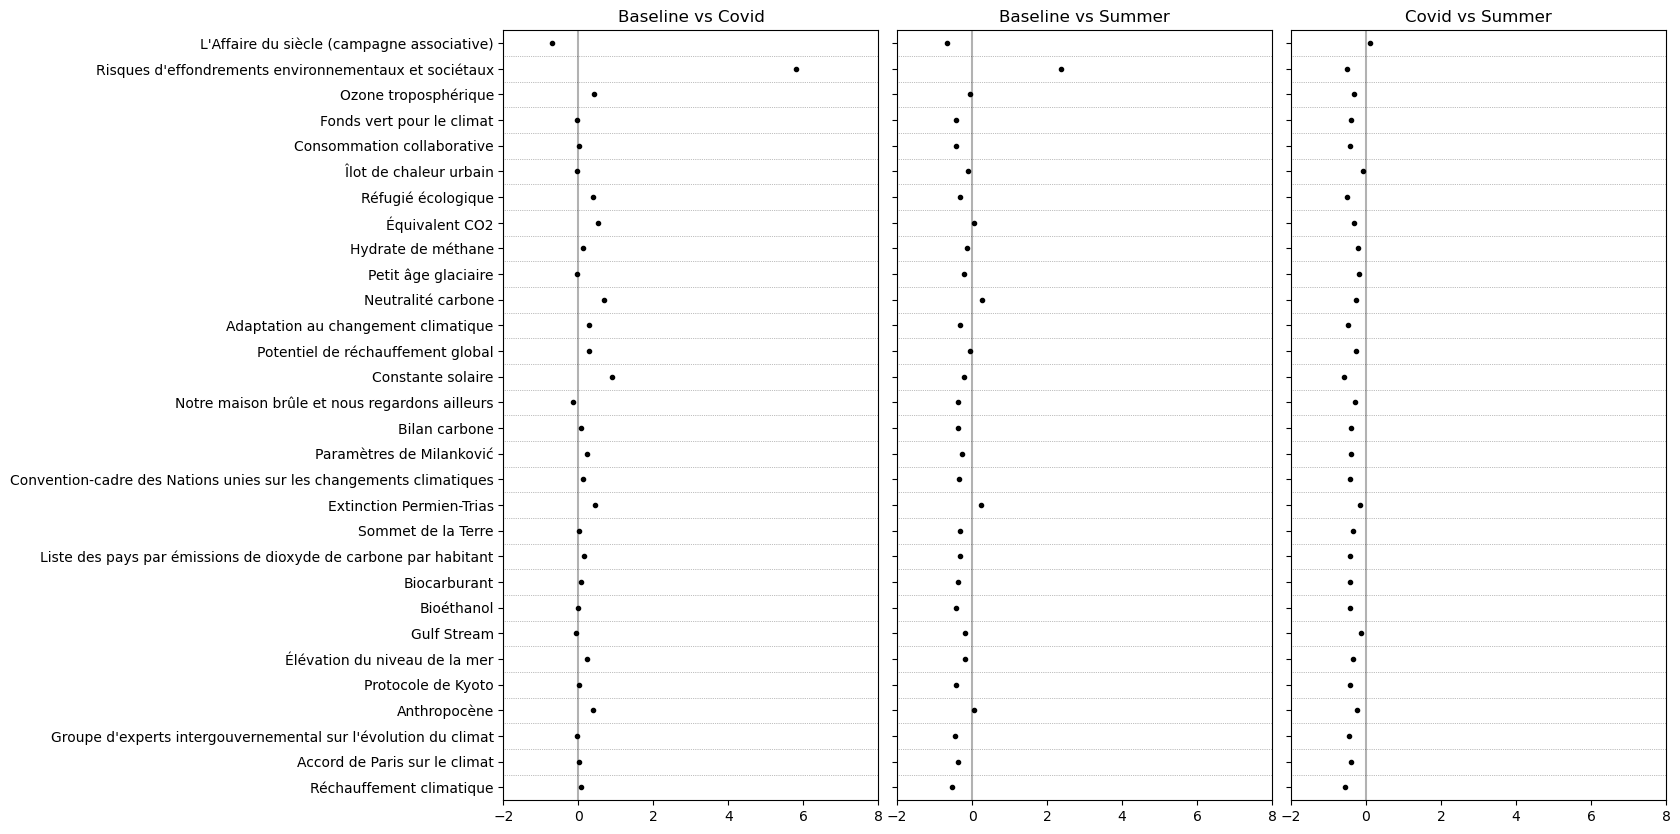

In [40]:
#Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True, sharex=True,
                       gridspec_kw={"hspace": 0.15, "wspace": 0.05})

for idx, article in enumerate(climate_change_complete_fr['Article']):
    for idy, col in enumerate(["BC_diff", "BS_diff", "CS_diff"]):
        row = dict(climate_change_complete_fr[climate_change_complete_fr.Article == article].iloc[0])
        marker = "."
        #marker = "." if row["pval"] else "x"

        axes[idy].scatter([row[col]], [article], color="black", marker=marker, zorder=2)
        #axes[idy].plot([row["low"], row["high"]], [idx, idx], color="#e41a1c", zorder=1)
        axes[idy].axhline(idx+0.5, lw=0.5, ls=":", color='black', alpha=0.5)

    _ = axes[idy].set_yticks(range(0, idx+1))
    _ = axes[idy].set_ylim([-0.5,idx+0.5])
    _ = axes[idy].set_xlim([-2, 8])

for ax in axes:
    ax.axvline(0, zorder=0, color="black", ls="-", alpha=0.3)
    
axes[0].set_title("Baseline vs Covid")
axes[1].set_title("Baseline vs Summer")
axes[2].set_title("Covid vs Summer")
plt.show()

In [44]:
climate_change_cat_baseline_no

Title    Average
0                            Global oppvarming  90.410397
1   Liste over land etter karbondioksidutslipp  78.210670
2                                 Klimaendring  26.782490
3                               FNs klimapanel  19.499316
4            Konsekvenser av global oppvarming  14.530780
6                               CO2-ekvivalent  11.393981
5                     Karbonfangst og -lagring   9.146375
9                                Grønlandsisen   8.829001
7                              Klimarealistene   7.374829
10                                Klimaskepsis   7.355677
11                              Miljøflyktning   6.752394
12                                   GWP-verdi   4.580027
16                      Klimaendringer i Norge   2.767442
15                           Hockeykøllegrafen   2.588235
17                                  Atomvinter   2.181943
14                                     Biokull   2.136799
22                               Klimapolitikk   2.054720
20                    IPCCs femte hovedrapport   2.043776
21                             Strålingspådriv   2.039672
18                           Global nedkjøling   1.958960
8             Tilbakekoblingsmekanisme (klima)   1.809850
23                              Klimafølsomhet   1.686731
13                          Vippepunkt (klima)   1.645691
27                              Global dimming   1.132695
26                               Iskjerneprøve   1.103967
19                                 Klimapådriv   1.023256
31                          Klimarettferdighet   1.019152
32                          Global klimamodell   0.991792
30                                      LULUCF   0.963064
28                                  Karbonsluk   0.912449

In [76]:
#Function to retrieve the differentially expressed themes

def differentially_expressed_themes( climate_change_cat_country, country_index, intervention_table, num_articles_graph, graph_bool, numb_returns):
    climate_change_cat_covid =  pd.DataFrame(climate_change_cat_country.set_index('Title').loc[:,interventions.loc['1st case',country_index].strftime('%Y-%m-%d'):interventions.loc['Normalcy',country_index].strftime('%Y-%m-%d')].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:].nlargest(num_articles_graph,'Average')
    article = climate_change_cat_covid['Title'].values
    climate_change_cat_baseline = pd.DataFrame(climate_change_cat_country.set_index('Title').loc[:,'2018-01-01':interventions.loc['1st case',country_index].strftime('%Y-%m-%d')].copy().mean(axis=1),columns=['Average']).reset_index()
    climate_change_cat_baseline = climate_change_cat_baseline[climate_change_cat_baseline.Title.isin(article)]
    climate_change_cat_summer = pd.DataFrame(climate_change_cat_country.set_index('Title').loc[:,interventions.loc['Normalcy',country_index].strftime('%Y-%m-%d'):'2020-09-01'].copy().mean(axis=1),columns=['Average']).reset_index().iloc[:-1,:]
    climate_change_cat_summer = climate_change_cat_summer[climate_change_cat_summer.Title.isin(article)]

    climate_change_complete =  pd.DataFrame(columns=['Article', 'Baseline', 'Covid', 'Summer', 'BC_diff', 'BS_diff', 'CS_diff'])
    climate_change_complete.Article = climate_change_cat_baseline.Title
    climate_change_complete.Baseline = climate_change_cat_baseline.Average
    climate_change_complete.Covid = climate_change_cat_covid.Average
    climate_change_complete.Summer = climate_change_cat_summer.Average

    #Differences are computed in %
    climate_change_complete.BC_diff = (climate_change_cat_covid.Average - climate_change_cat_baseline.Average)/climate_change_cat_baseline.Average
    climate_change_complete.BS_diff = (climate_change_cat_summer.Average - climate_change_cat_baseline.Average)/climate_change_cat_baseline.Average
    climate_change_complete.CS_diff = (climate_change_cat_summer.Average - climate_change_cat_covid.Average)/climate_change_cat_covid.Average
    if graph_bool:
        fig, axes = plt.subplots(1, 3, figsize=(15, 10), sharey=True, sharex=True,
                               gridspec_kw={"hspace": 0.15, "wspace": 0.05})

        for idx, article in enumerate(climate_change_complete['Article']):
            for idy, col in enumerate(["BC_diff", "BS_diff", "CS_diff"]):
                row = dict(climate_change_complete[climate_change_complete.Article == article].iloc[0])
                marker = "."
                #marker = "." if row["pval"] else "x"

                axes[idy].scatter([row[col]], [article], color="black", marker=marker, zorder=2)
                #axes[idy].plot([row["low"], row["high"]], [idx, idx], color="#e41a1c", zorder=1)
                axes[idy].axhline(idx+0.5, lw=0.5, ls=":", color='black', alpha=0.5)

            _ = axes[idy].set_yticks(range(0, idx+1))
            _ = axes[idy].set_ylim([-0.5,idx+0.5])
            _ = axes[idy].set_xlim([-2, 8])

        for ax in axes:
            ax.axvline(0, zorder=0, color="black", ls="-", alpha=0.3)

        axes[0].set_title("Baseline vs Covid")
        axes[1].set_title("Baseline vs Summer")
        axes[2].set_title("Covid vs Summer")
        plt.show()
        to_return = climate_change_complete.nlargest(numb_returns, 'BC_diff')
        to_return['Country']=country_index
        
    return to_return

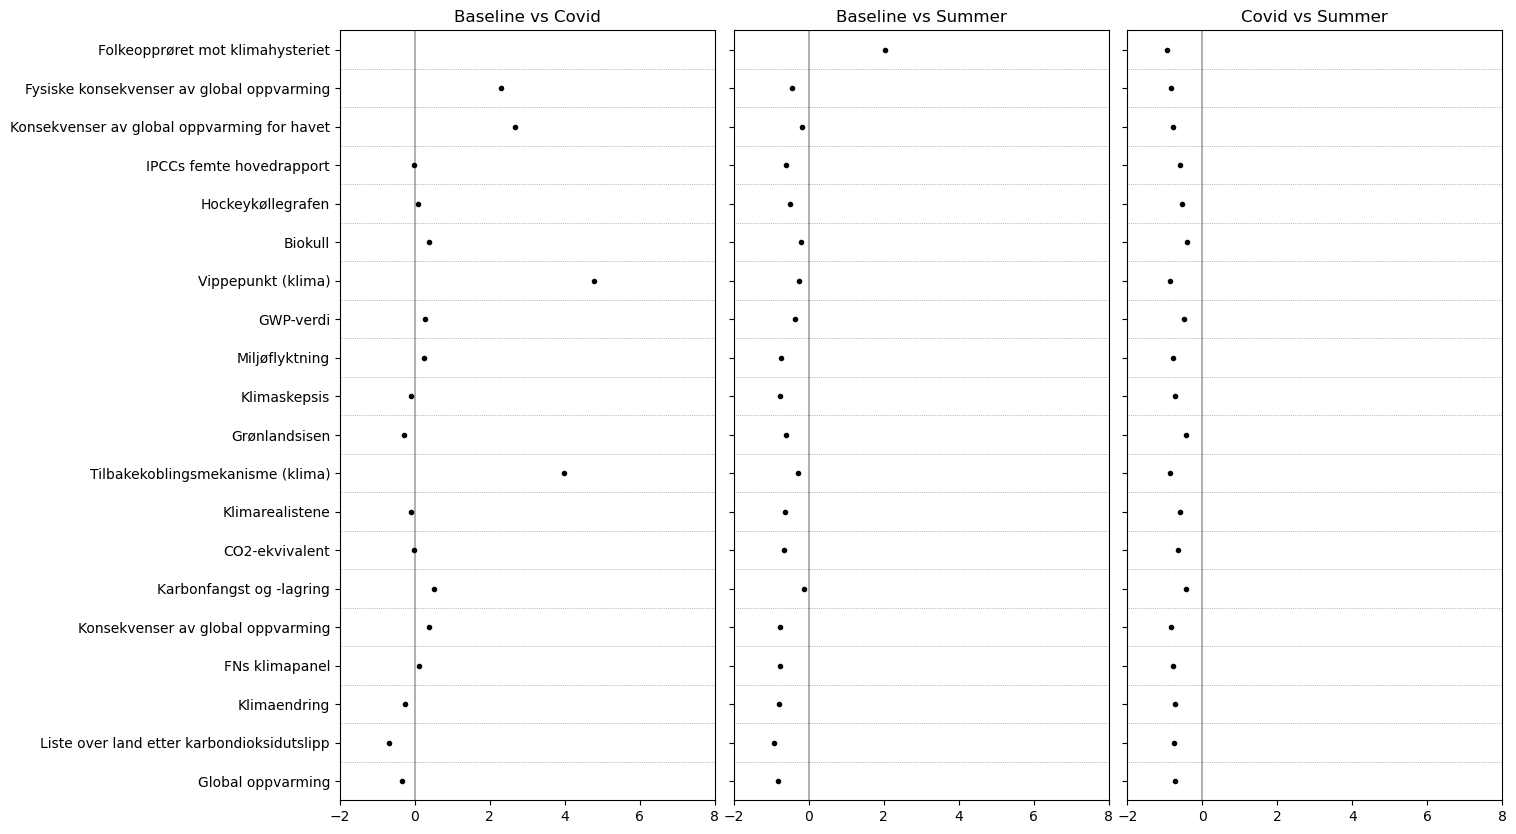

Article  Baseline  Covid    Summer    BC_diff  \
34  Folkeopprøret mot klimahysteriet  0.124524   6.17  0.377778  48.548878   
13                Vippepunkt (klima)  1.809403  10.44  1.355556   4.769860   
8   Tilbakekoblingsmekanisme (klima)  2.857687  14.25  2.077778   3.986550   

     BS_diff   CS_diff Country  
34  2.033787 -0.938772      no  
13 -0.250827 -0.870158      no  
8  -0.272916 -0.854191      no

In [79]:
differentially_expressed_themes(climate_change_cat_no, 'no', interventions,20, True, 3)

#Tilbakekoblingsmekamism means 'Climate change feedback' not necesseraly related to urgency


Could we pull all of the most differentially expressed during covid, and then see if clustering them between 'urgent' and 'non urgent' can predict whether the country had high or low impact factor?

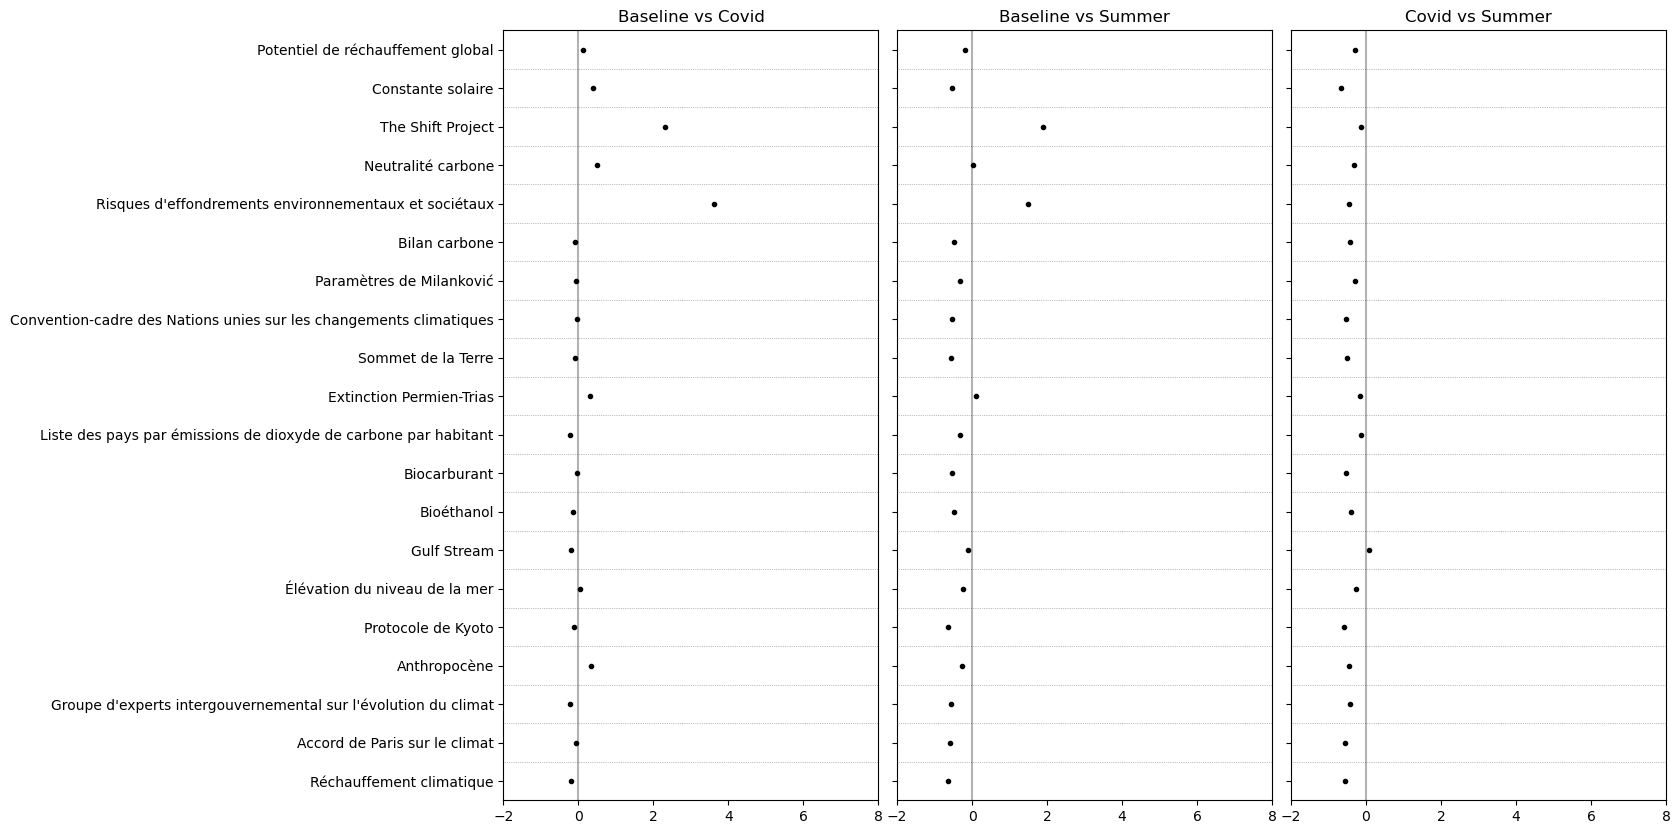

Article   Baseline       Covid  \
15  Risques d'effondrements environnementaux et so...  37.671088  173.627329   
19                                  The Shift Project  30.291777  100.012422   
16                                 Neutralité carbone  46.217507   69.298137   

       Summer   BC_diff   BS_diff   CS_diff Country  
15  94.161290  3.609034  1.499564 -0.457682      fr  
19  87.112903  2.301636  1.875794 -0.128979      fr  
16  47.741935  0.499392  0.032984 -0.311065      fr

In [77]:
differentially_expressed_themes(climate_change_cat_fr, 'fr', interventions,20, True, 3)

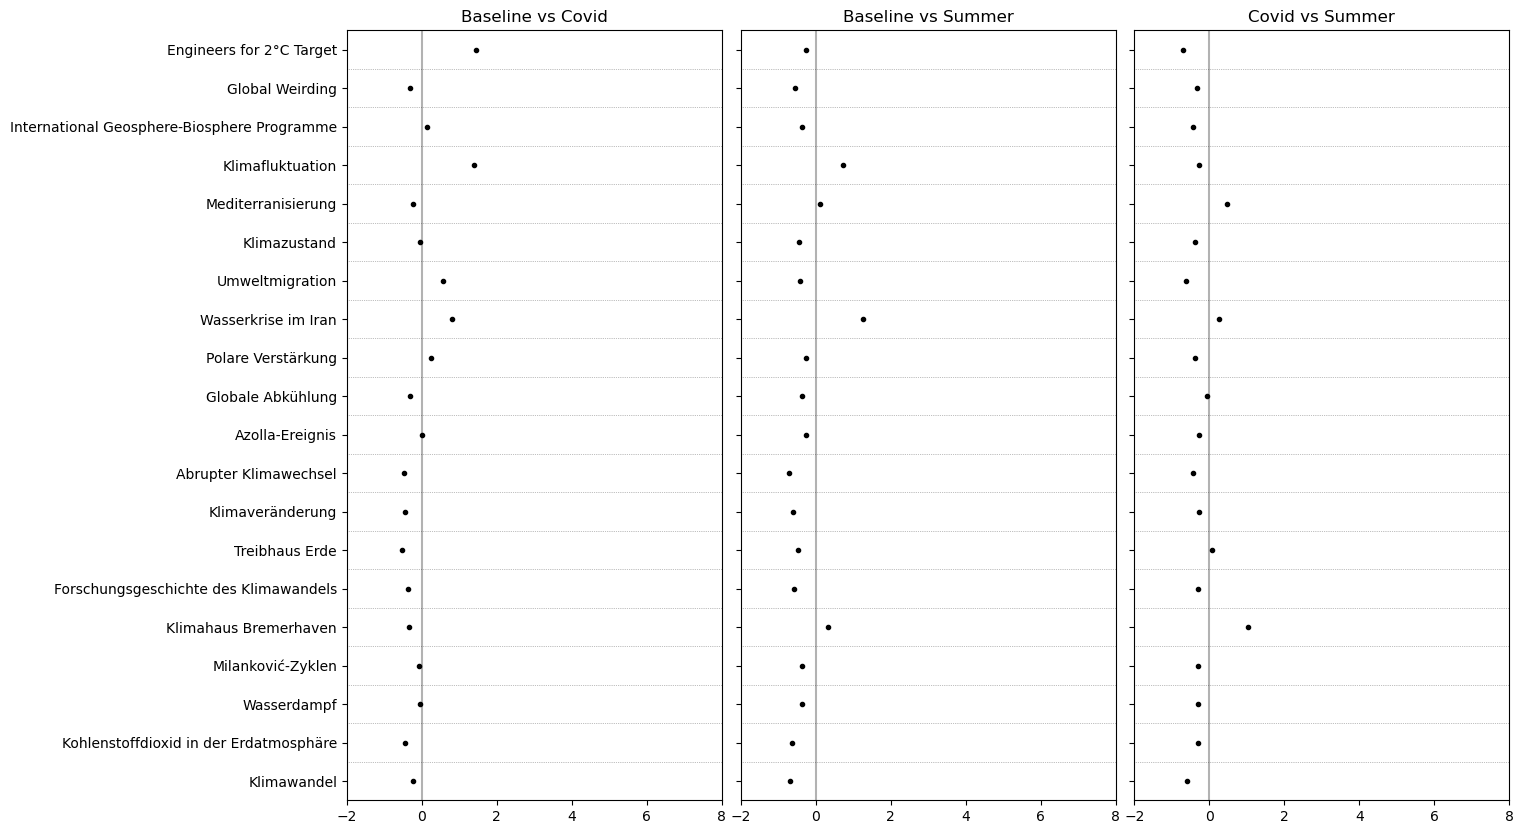

Article  Baseline     Covid    Summer   BC_diff  \
19  Engineers for 2°C Target  0.418758  1.024096  0.314815  1.445555   
16          Klimafluktuation  0.988111  2.373494  1.703704  1.402052   
12       Wasserkrise im Iran  2.385733  4.325301  5.407407  0.812986   

     BS_diff   CS_diff Country  
19 -0.248218 -0.692593      de  
16  0.724203 -0.282196      de  
12  1.266560  0.250181      de

In [80]:
differentially_expressed_themes(climate_change_cat_de, 'de', interventions,20, True, 3)

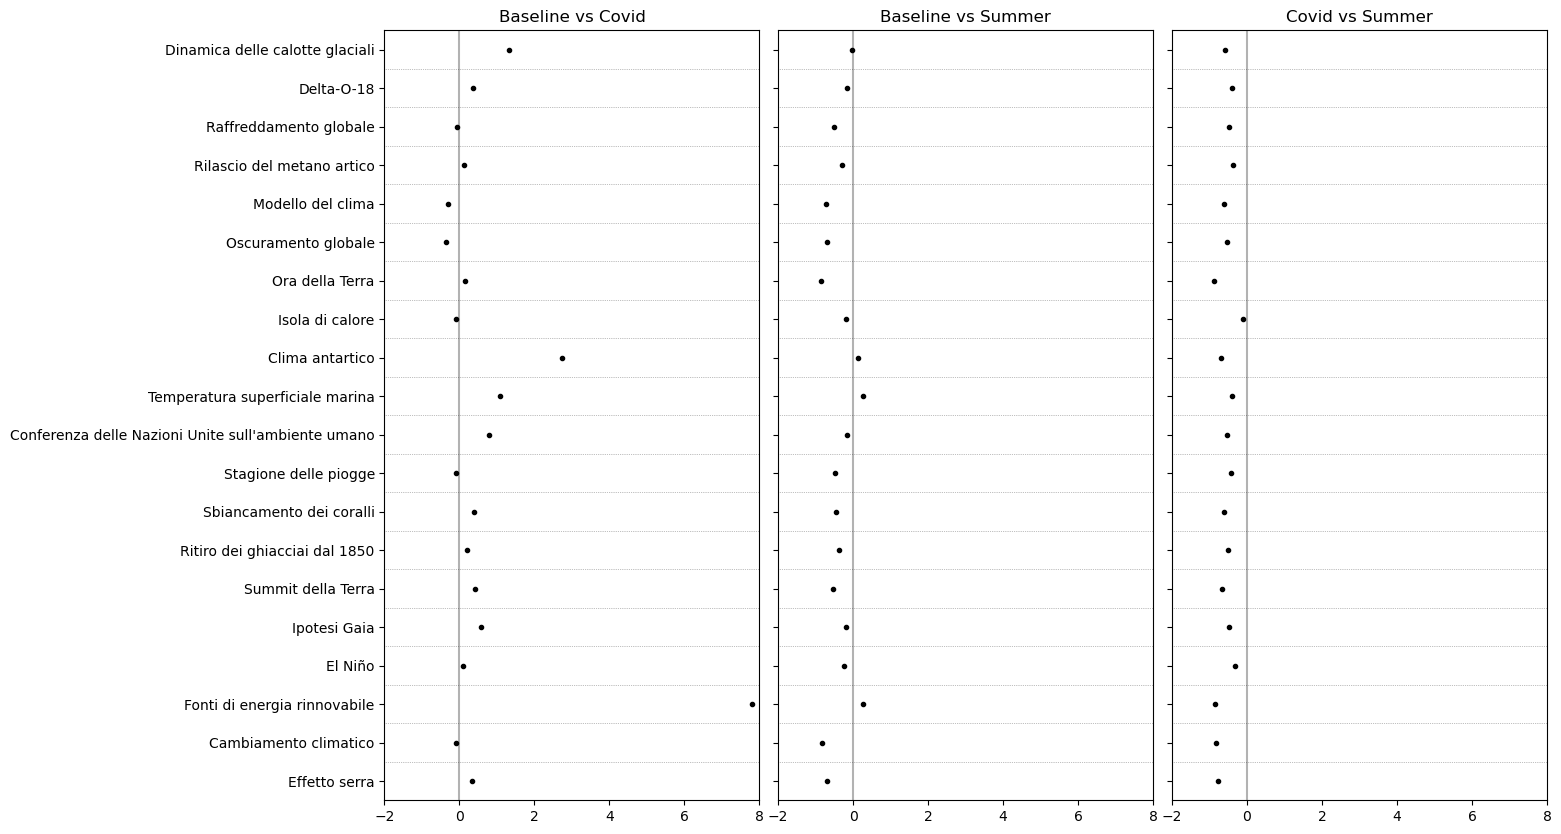

Article   Baseline       Covid      Summer  \
2      Fonti di energia rinnovabile  88.103811  775.952703  110.955882   
11                  Clima antartico  10.557162   39.378378   11.926471   
24  Dinamica delle calotte glaciali   1.809461    4.175676    1.750000   

     BC_diff   BS_diff   CS_diff Country  
2   7.807255  0.259377 -0.857007      it  
11  2.730016  0.129704 -0.697131      it  
24  1.307690 -0.032861 -0.580906      it

In [81]:
differentially_expressed_themes(climate_change_cat_it, 'it', interventions,20, True, 3)